## Imports

In [3]:
import os
# Set CUDA_VISIBLE_DEVICES before importing torch so the chosen physical GPU is exposed correctly.
# Use the physical GPU index reported by `nvidia-smi` (e.g. "1" for the second card).

# Now import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
# import holoviews as hv
import tifffile
import careamics
from careamics import CAREamist
from careamics.utils.metrics import scale_invariant_psnr, psnr, avg_range_invariant_psnr
import ramanspy as rpT
import pandas
from typing import List
import xarray as xa
import platform
import subprocess
import sys
sys.path.append('../RamaN2V/')  # for plot_utils.py
from plot_utils import compare_spectra, SpectralData
import plot_utils as pu
# Diagnostics: confirm available physical GPUs (nvidia-smi) and what PyTorch sees.
# This verifies mapping between physical index (nvidia-smi) and PyTorch visible index.
try:
    smi = subprocess.check_output(
        ["nvidia-smi", "--query-gpu=index,name,memory.total", "--format=csv,noheader"],
        stderr=subprocess.STDOUT
    ).decode().strip()
except Exception:
    smi = "nvidia-smi not available or failed"
print("nvidia-smi GPUs (physical index, name, memory):\n", smi)
print(f"CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")
print(f"Python platform: {platform.platform()}")
print(f"PyTorch version: {torch.__version__}")

# After setting CUDA_VISIBLE_DEVICES='1', physical GPU 1 will appear as cuda:0 to PyTorch.
if torch.cuda.is_available():
    print(f"PyTorch sees {torch.cuda.device_count()} CUDA device(s)")
    device = torch.device("cuda:0")          # use cuda:0 because only the selected physical GPU is visible
    torch.cuda.set_device(0)                 # set default device index within the visible devices
    print(f"Using PyTorch device: {device}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif torch.backends.mps.is_available():
    print("PyTorch sees an Apple Silicon GPU (MPS backend).")
    device = torch.device("mps")
    print(f"Using PyTorch device: {device}")
else:
    print("No CUDA GPUs available to PyTorch (torch.cuda.is_available() == False).")
    print("If you expect GPUs, restart the kernel after changing CUDA_VISIBLE_DEVICES, or launch Jupyter with the env var set:")
    print("  CUDA_VISIBLE_DEVICES=1 jupyter lab  # or jupyter notebook")
    print("Ensure NVIDIA drivers and CUDA are installed and compatible with torch build.")
print(os.getcwd())

# %matplotlib widget
%load_ext autoreload
%autoreload 2

nvidia-smi GPUs (physical index, name, memory):
 nvidia-smi not available or failed
CUDA_VISIBLE_DEVICES=None
Python platform: macOS-26.2-arm64-arm-64bit-Mach-O
PyTorch version: 2.8.0
PyTorch sees an Apple Silicon GPU (MPS backend).
Using PyTorch device: mps
/Users/tom/Developments/Raman/flogen


### Load Fluorophores from CSV

In [4]:
from ramanlib.bleaching import load_fluorophores
from flogen import SyntheticConfig, SyntheticBleachingDataset

# Load real fluorophores
fluorophore_ds = load_fluorophores(
    './data/fluorophores/uniform.csv',
    laser_nm=532.0,
    crop_range=(500, 1700))
fluorophore_ds



ModuleNotFoundError: No module named 'flogen'

### Visualise Loaded Fluorophores

(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

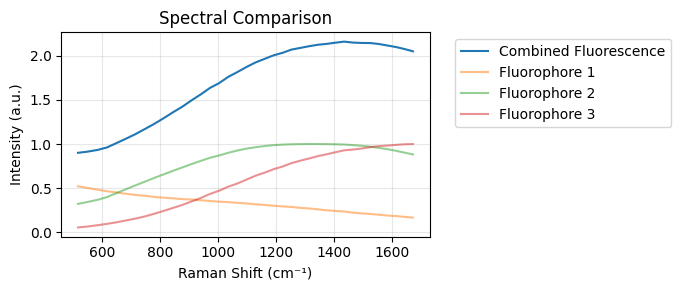

In [5]:
combined_fluorescence = pu.convert_to_spectral_data(data=fluorophore_ds.isel(sample=[0,1,2]).sum(dim="sample")['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values)
fluorophore_ds_spectra = pu.convert_to_spectral_data(data=fluorophore_ds['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values)
pu.compare_spectra(
    [combined_fluorescence, pu.convert_to_spectral_data(data=fluorophore_ds.isel(sample=0)['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values)  , pu.convert_to_spectral_data(data=fluorophore_ds.isel(sample=1)['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values), pu.convert_to_spectral_data(data=fluorophore_ds.isel(sample=2)['intensity'].values, wavenumbers=fluorophore_ds.wavenumber.values)],
    titles=["Combined Fluorescence", "Fluorophore 1", "Fluorophore 2", "Fluorophore 3"],
    n_samples=3,
    height=3,
    alphas=[1.0, 0.5, 0.5, 0.5],
    width=7,
)

### Create Bleaching Dataset Using Loaded Fluorophores

In [ ]:
import sys, importlib
from ATCCLoader import load_data

importlib.reload(sys.modules['flogen'])
sys.path.append("../RamaN2V/")  # for plot_utils.py

atcc_dataset = load_data("../RamaN2V/data/ATCC/")

# Preprocess as desired
atcc_xr = atcc_dataset.to_xarray(
    crop=(500, 1700),
    remove_outliers=True,
    remove_incomplete=True,
    despike=True,
)


In [2]:

#  Generate synthetic bleaching data
config = SyntheticConfig(
    n_samples=100,
    bleaching_interval=0.1,         # 0.1s between frames
    bleaching_max_time=15.0,        # 15s total (151 frames)
    integration_times=["15s"],
    decay_rate_min=0.05,            # slowest: τ = 20s
    decay_rate_max=5,               # fastest: τ = 0.2s
    n_fluorophores=3,
    use_polynomial_fluorophores=False,
    fluorophore_polynomial_degree=3,
    decay_sampling="log_uniform",
    poisson_noise_scale=0.1,
    gaussian_noise_scale=0.005,
    fr_ratio_min=2.0,
    fr_ratio_max=3.0,
    fluorophore_weight_min=0.5,
    fluorophore_weight_max=2.0,
    noise_type="poisson_gaussian",
    interpolation_method="polynomial",
)

# Generate with real fluorophores
generator = SyntheticBleachingDataset(
    config,
    atcc_xr,
    fluorophore_xr=fluorophore_ds,  # Pass real spectra
)
synthetic_ds = generator.generate()


def calculate_mse(true: np.ndarray, noisy: np.ndarray) -> float:
    """Compute Mean Squared Error between ground truth and noisy data."""
    return np.mean((true - noisy) ** 2)

def calculate_snr(true: np.ndarray, noisy: np.ndarray) -> float:
    """Compute Signal-to-Noise Ratio (SNR) in dB between ground truth and noisy data."""
    signal_power = np.mean(true ** 2)
    noise_power = np.mean((true - noisy) ** 2)
    if noise_power == 0:
        return float('inf')
    return 10 * np.log10(signal_power / noise_power)

# Example usage for the first bleaching_time point
gt = synthetic_ds["intensity_clean"].sel(bleaching_time=0).values
noisy = synthetic_ds["intensity_raw"].sel(bleaching_time=0).values

mse = calculate_mse(gt, noisy)
snr = calculate_snr(gt, noisy)

print(f"MSE (noise level): {mse:.2f}")
print(f"SNR (dB): {snr:.2f}")


NameError: name 'SyntheticConfig' is not defined

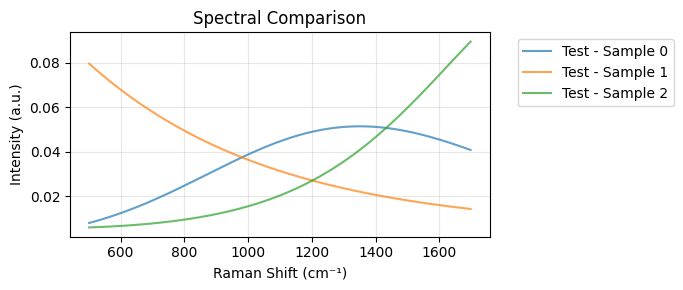

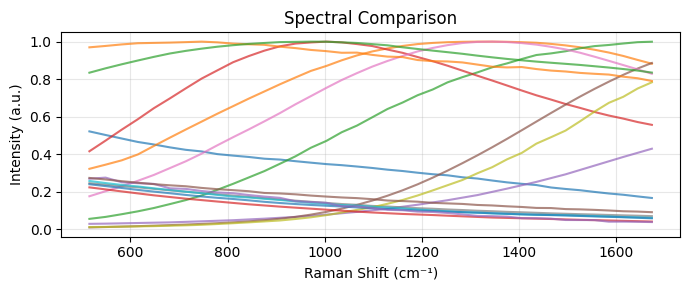

In [7]:
pu.compare_spectra(
    [pu.convert_to_spectral_data(synthetic_ds, intensity_var="fluorophore_bases_gt")],
    titles=["Test"],
    n_samples=3,
    height=3,
    width=7,
)


plt_out, fig = pu.compare_spectra(
    [pu.convert_to_spectral_data(fluorophore_ds, intensity_var="intensity")],
    titles=["Test"],
    n_samples=fluorophore_ds.sample.size,
    legend=False,
    height=3,
    width=7,
)



In [6]:
# # Extract normalized intensity data
# X_0pt1s = very_low_snr['intensity_normalised'].values
# X_1s = low_snr['intensity_normalised'].values  # (n_samples, n_wavenumbers)
# X_10s = high_snr['intensity_normalised'].values

# Create species labels (map species names to integers)
species_names = synthetic_ds["species"].values
unique_species = np.unique(species_names)
species_to_int = {name: i for i, name in enumerate(unique_species)}
y = np.array([species_to_int[name] for name in species_names])

print(f"Data shapes: {synthetic_ds.dims}")
print(f"Number of classes: {len(unique_species)}")
print(f"Species mapping:")
for species, idx in species_to_int.items():
    count = (y == idx).sum()
    print(f"  {idx}: {species} ({count} samples)")

Data shapes: FrozenMappingWarningOnValuesAccess({'sample': 1000, 'bleaching_time': 101, 'wavenumber': 630, 'fluorophore': 3})
Number of classes: 7
Species mapping:
  0: Acinetobacter baumannii (118 samples)
  1: Enterococcus faecalis (144 samples)
  2: Escherichia coli (262 samples)
  3: Klebsiella Pneumoniae (72 samples)
  4: Pseudomonas aeruginosa (139 samples)
  5: Staphylococcus aureus (200 samples)
  6: Staphylococcus epidermidis (65 samples)


## Fluorescence Plotting Functions

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15. ]


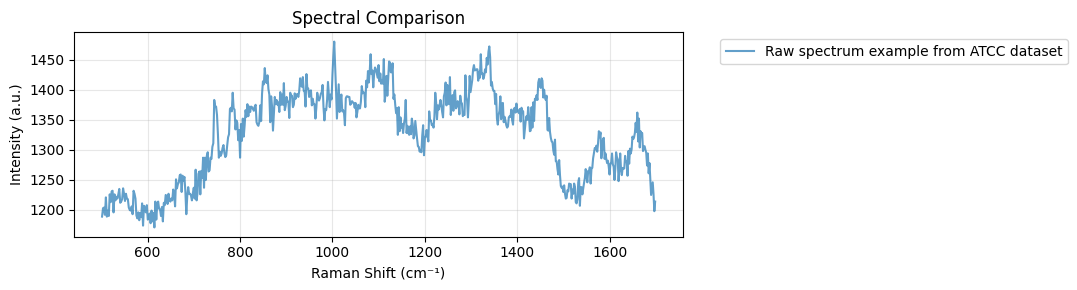

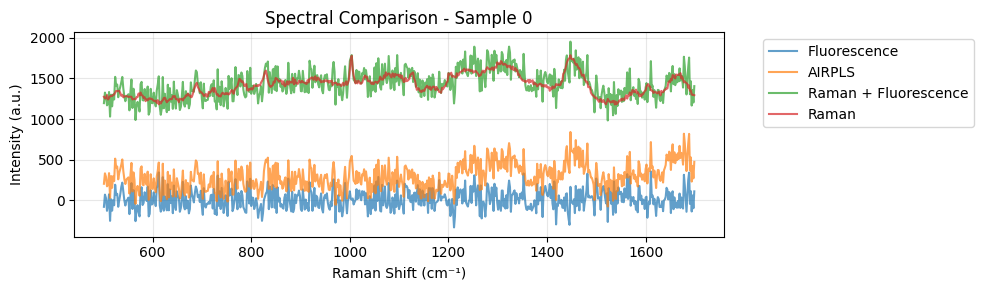

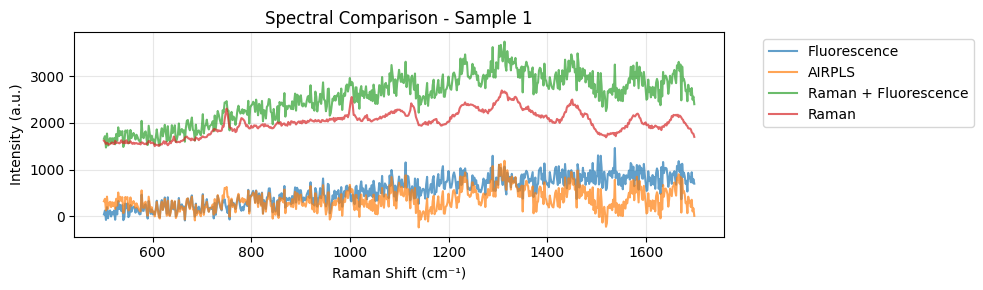

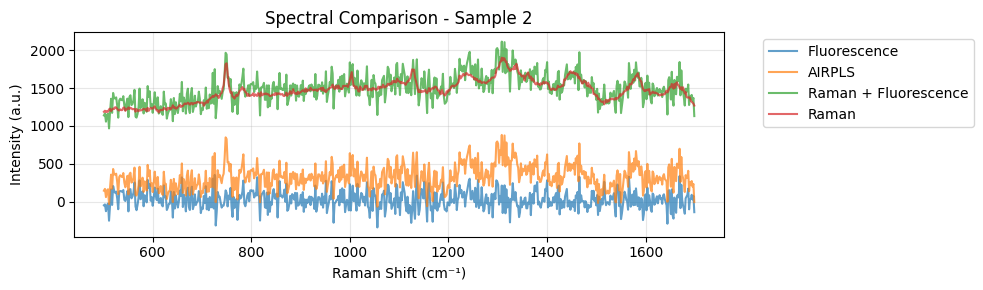

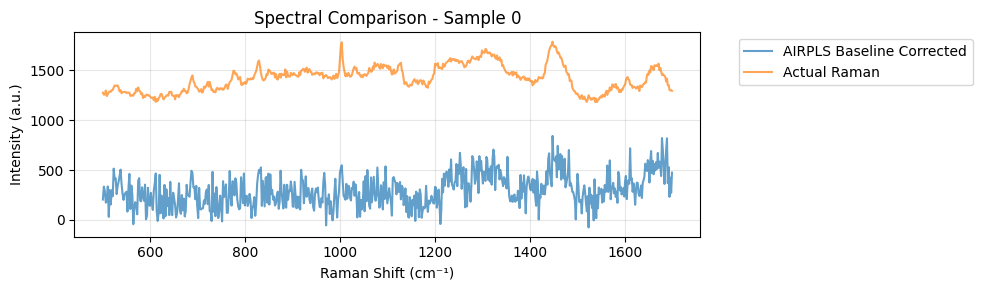

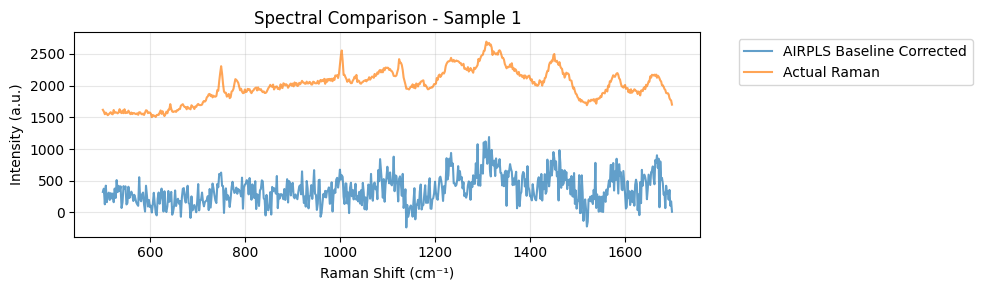

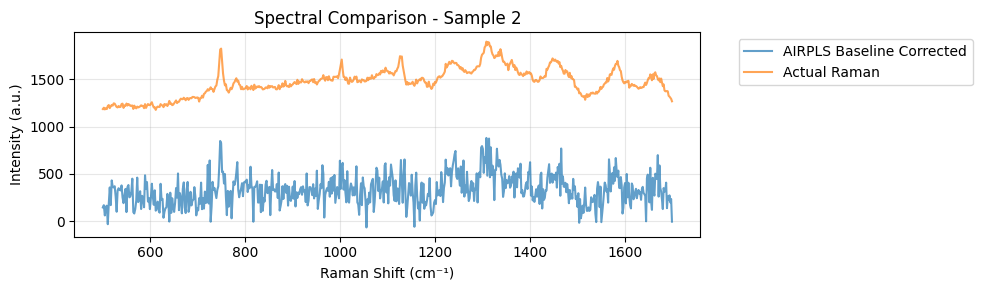

(<Figure size 1000x300 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison - Sample 2'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

In [11]:

import ramanspy as rp

# Extract intensity and wavenumber arrays for a single sample at 15s integration time
intensity = atcc_xr.sel(integration_time='15s')
wavenumber = atcc_xr.sel(integration_time='15s')



# Visualize the raw spectrum using the provided plotting utility
compare_spectra(
    [pu.convert_to_spectral_data(intensity)],
    titles=['Raw spectrum example from ATCC dataset'],
    n_samples=1,
    width=11,
    height=3
)

print(synthetic_ds.bleaching_time.values)
time_point = 10.0
raman = pu.convert_to_spectral_data(synthetic_ds.sel(bleaching_time=0.1), intensity_var='raman_gt')
fluorescence = (synthetic_ds.intensity_raw - synthetic_ds.raman_gt).sel(bleaching_time=time_point)


compare_spectra(
    [pu.convert_to_spectral_data(fluorescence),  pu.convert_to_spectral_data(synthetic_ds.sel(bleaching_time=time_point), intensity_var='intensity_raw').apply_ramanspy_preprocessing(rp.preprocessing.baseline.AIRPLS()), pu.convert_to_spectral_data(synthetic_ds.sel(bleaching_time=time_point), intensity_var='intensity_raw'), raman],
    titles=["Fluorescence","AIRPLS", "Raman + Fluorescence", "Raman"],
    n_samples=3,
    height=3,
    separate_samples=True,
    width=10,
)

# Convert AIRPLS-processed and actual Raman to SpectralData, then normalise both for direct comparison
airpls_data = pu.convert_to_spectral_data(
    synthetic_ds.sel(bleaching_time=time_point), intensity_var='intensity_raw'
).apply_ramanspy_preprocessing(rp.preprocessing.baseline.AIRPLS())

# Normalise both spectra to unit norm for shape comparison
airpls_data_normalised = airpls_data
raman_normalised = raman

compare_spectra(
    [airpls_data_normalised, raman_normalised],
    titles=["AIRPLS Baseline Corrected", "Actual Raman"],
    n_samples=3,
    height=3,
    separate_samples=True,
    width=10,
)

In [24]:
# Import the corrected visualization utilities
import sys
sys.path.append(".")  # Add current directory to path
from ramanlib.bleaching.visualize import (
    plot_decomposition,
    plot_stacked_decomposition,
    plot_temporal_decomposition,

)
sample_idx = 10


fig = plot_decomposition(synthetic_ds, sample_idx=sample_idx, time_seconds=1.0)
plt.show()

fig = plot_temporal_decomposition(synthetic_ds, sample_idx=sample_idx)
plt.show()

# fig = plot_stacked_decomposition(synthetic_ds, sample_idx=sample_idx, time_seconds=0.1)
# plt.show()

from ramanlib.bleaching.visualize import visualise_decomposition_3d

# Create figure
fig = visualise_decomposition_3d(synthetic_ds, sample_idx=1)

# Display interactively in notebook
fig.show()



[autoreload of flogen failed: Traceback (most recent call last):
  File "/Users/tom/miniconda3/envs/ML/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tom/miniconda3/envs/ML/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
  File "/Users/tom/miniconda3/envs/ML/lib/python3.13/importlib/__init__.py", line 129, in reload
    _bootstrap._exec(spec, module)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 1026, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/tom/Developments/Raman/flogen/flogen.py", line 10, in <module>
    from ramanlib.bleaching.utils.bleaching_utils import (
    ...<4 lines>...
    )
  File "/Users/tom/Develop

ImportError: cannot import name 'plot_stacked_decomposition' from 'ramanlib.bleaching.visualize' (/Users/tom/Developments/Raman/flogen/ramanlib/bleaching/visualize.py)

## Exponential Fitting Threshold

Testing 20 configurations on 1 samples

5 pts: 3-exp 
10 pts: 3-exp 
15 pts: 3-exp 
20 pts: 3-exp 
25 pts: 3-exp 
30 pts: 3-exp 
35 pts: 3-exp 
40 pts: 3-exp 
45 pts: 3-exp 
50 pts: 3-exp 
55 pts: 3-exp 
60 pts: 3-exp 
65 pts: 3-exp 
70 pts: 3-exp 
75 pts: 3-exp 
80 pts: 3-exp 
85 pts: 3-exp 
90 pts: 3-exp 
95 pts: 3-exp 
100 pts: 3-exp SUMMARY

3-Component Model:
------------------------------------------------------------
Points     R² (full)       RMSE            Success   
------------------------------------------------------------
5          -4.1060         24099.7769      100%
10         0.6811         6022.5341       100%
15         0.7104         5739.3886       100%
20         0.8900         3536.5234       100%
25         0.7434         5402.0943       100%
30         nan         nan             0%
35         1.0000         5.6402          100%
40         nan         nan             0%
45         1.0000         0.1250          100%
50         nan         nan             0%
5

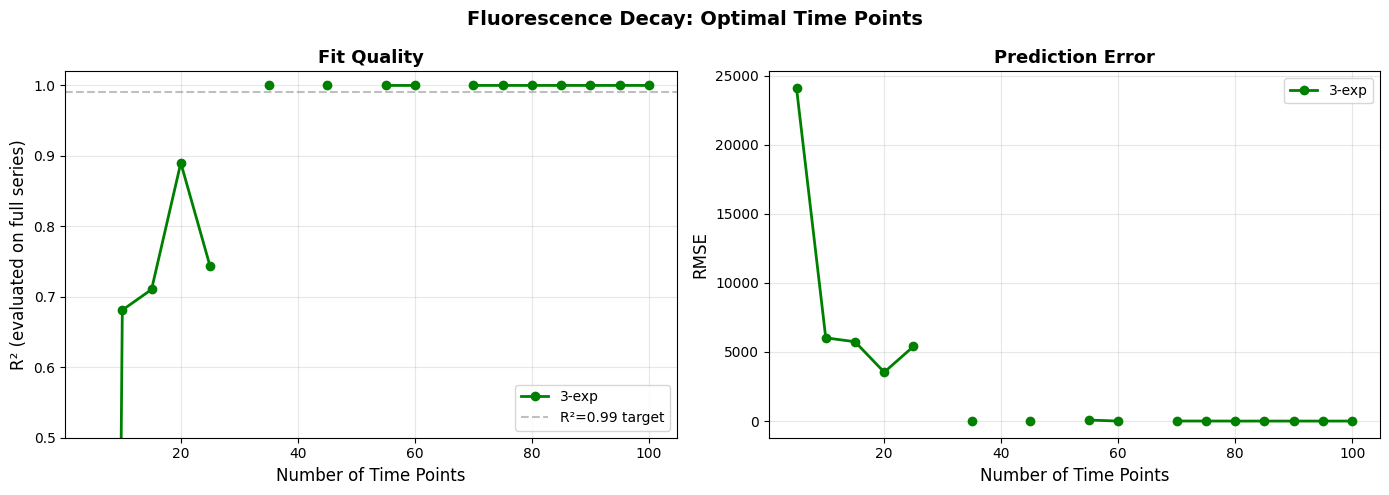

KeyError: 1

In [94]:
import numpy as np
import xarray as xr
from typing import Dict, Any, List, Tuple, Optional
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import OptimizeWarning

# Suppress curve_fit warnings
warnings.filterwarnings('ignore', category=OptimizeWarning)

# Define exponential models
def single_exp(t, A, tau, offset):
    return A * np.exp(-t / tau) + offset

def double_exp(t, A1, tau1, A2, tau2, offset):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + offset

def triple_exp(t, A1, tau1, A2, tau2, A3, tau3, offset):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + A3 * np.exp(-t / tau3) + offset

def fit_exponential_mixture(
    time_axis: np.ndarray,
    signal: np.ndarray,
    n_components: int = 2,
    maxfev: int = 5000
) -> Tuple[np.ndarray, np.ndarray, dict]:
    """Fit exponential mixture, return parameters and info dict with R^2 and RMSE."""
    if n_components == 1:
        func = single_exp
        initial_guess = [signal.max() - signal.min(), 1.0, signal.min()]
        bounds = ([0, 1e-6, -np.inf], [np.inf, 100, np.inf])
    elif n_components == 2:
        func = double_exp
        amp = (signal.max() - signal.min()) / 2
        initial_guess = [amp, 0.1, amp, 1.0, signal.min()]
        bounds = ([0, 1e-6, 0, 1e-6, -np.inf], [np.inf, 100, np.inf, 100, np.inf])
    else:
        func = triple_exp
        amp = (signal.max() - signal.min()) / 3
        initial_guess = [amp, 0.01, amp, 0.3, amp, 3.0, signal.min()]
        bounds = ([0, 1e-6, 0, 1e-6, 0, 1e-6, -np.inf], 
                  [np.inf, 100, np.inf, 100, np.inf, 100, np.inf])
    
    try:
        popt, pcov = curve_fit(func, time_axis, signal, p0=initial_guess, bounds=bounds, maxfev=maxfev)
        fitted = func(time_axis, *popt)
        residuals = signal - fitted
        r_squared = 1 - (np.sum(residuals**2) / np.sum((signal - signal.mean())**2))
        info = {
            'r_squared': r_squared,
            'rmse': np.sqrt(np.mean(residuals ** 2)),
            'function': func
        }
        return popt, pcov, info
    except Exception as e:
        return None, None, {'error': str(e)}


def find_optimal_timepoints(
    ds: xr.Dataset,
    n_test_samples: int = 30,
    min_points: int = 5,
    max_points: int = None,
    step: int = 10,
    seed:  Optional[int] = None,
    test_n_components: List[int] = [1, 2, 3]
) -> Dict[str, Any]:
    """Find optimal number of time points for fluorescence decay modeling."""
    np.random.seed(seed)
    
    time = ds.bleaching_time.values
    # Extract pure fluorescence (subtract constant Raman signal)
    fluorescence = ds.intensity_clean- ds.raman_gt
    mean_decay = fluorescence.mean(dim="wavenumber")
    
    if max_points is None:
        max_points = len(time)
    
    n_samples = min(n_test_samples, mean_decay.shape[0])
    sample_indices = np.random.choice(mean_decay.shape[0], n_samples, replace=False)
    n_points_range = np.arange(min_points, max_points + 1, step)
    
   
    all_results = {}
    for n_comp in test_n_components:
        all_results[n_comp] = {
            'n_points': [],
            'r_squared_mean': [],
            'rmse_mean': [],
            'fit_success_rate': []
        }
    
    print(f"Testing {len(n_points_range)} configurations on {n_samples} samples")
    
    for n_pts in n_points_range:
        print(f"\n{n_pts} pts:", end=" ", flush=True)
        
        for n_comp in test_n_components:
            print(f"{n_comp}-exp", end=" ", flush=True)
            
            r2_list = []
            rmse_list = []
            success_count = 0
            
            for sample_idx in sample_indices:
                y_full = mean_decay.isel(sample=sample_idx).values
                t_subset = time[:n_pts]
                y_subset = y_full[:n_pts]
                
                popt, pcov, info = fit_exponential_mixture(t_subset, y_subset, n_components=n_comp, maxfev=10000)
                
                if popt is not None:
                    # Evaluate on FULL time series
                    y_pred_full = info['function'](time, *popt)
                    residuals_full = y_full - y_pred_full
                    r2_full = 1 - (np.sum(residuals_full ** 2) / np.sum((y_full - y_full.mean()) ** 2))
                    rmse_full = np.sqrt(np.mean(residuals_full ** 2))
                    
                    r2_list.append(r2_full)
                    rmse_list.append(rmse_full)
                    success_count += 1
            
            results = all_results[n_comp]
            results['n_points'].append(n_pts)
            results['r_squared_mean'].append(np.mean(r2_list) if r2_list else np.nan)
            results['rmse_mean'].append(np.mean(rmse_list) if rmse_list else np.nan)
            results['fit_success_rate'].append(success_count / n_samples)
    
    print("SUMMARY")
    for n_comp in test_n_components:
        results = all_results[n_comp]
        print(f"\n{n_comp}-Component Model:")
        print("-"*60)
        print(f"{'Points':<10} {'R² (full)':<15} {'RMSE':<15} {'Success':<10}")
        print("-"*60)
        for i in range(len(results['n_points'])):
            print(f"{results['n_points'][i]:<10} "
                  f"{results['r_squared_mean'][i]:.4f}         "
                  f"{results['rmse_mean'][i]:<15.4f} "
                  f"{results['fit_success_rate'][i]*100:.0f}%")
    print("="*60)
    
    return all_results


# Run analysis
ds = synthetic_ds
all_results = find_optimal_timepoints(ds, n_test_samples=1, step=5, test_n_components=[3])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {1: 'blue', 2: 'orange', 3: 'green'}
labels = {1: '1-exp', 2: '2-exp', 3: '3-exp'}

# R^2 plot
ax = axes[0]
for n_comp, results in all_results.items():
    r2 = np.array(results['r_squared_mean'])
    ax.plot(results['n_points'], r2, marker='o', label=labels[n_comp],
            color=colors[n_comp], linewidth=2, markersize=6)
ax.axhline(0.99, color='gray', linestyle='--', alpha=0.5, label='R²=0.99 target')
ax.set_xlabel('Number of Time Points', fontsize=12)
ax.set_ylabel('R² (evaluated on full series)', fontsize=12)
ax.set_title('Fit Quality', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.02])

# RMSE plot
ax = axes[1]
for n_comp, results in all_results.items():
    rmse = np.array(results['rmse_mean'])
    ax.plot(results['n_points'], rmse, marker='o', 
            label=labels[n_comp], color=colors[n_comp], linewidth=2, markersize=6)
ax.set_xlabel('Number of Time Points', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Prediction Error', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Fluorescence Decay: Optimal Time Points', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

for n_comp in [1, 2, 3]:
    results = all_results[n_comp]
    r2_arr = np.array(results['r_squared_mean'])
    rmse_arr = np.array(results['rmse_mean'])
    
    good_idx = np.where(r2_arr > 0.99)[0]
    if len(good_idx) > 0:
        idx = good_idx[0]
        n_pts = results['n_points'][idx]
        total_pts = len(synthetic_ds.bleaching_time)
        reduction = (1 - n_pts/total_pts) * 100
        
        print(f"\n{n_comp}-component: {n_pts} points ({reduction:.0f}% reduction)")
        print(f"  → R² = {r2_arr[idx]:.4f}, RMSE = {rmse_arr[idx]:.4f}")
    else:
        print(f"\n{n_comp}-component: Needs all points (R² < 0.99)")


(<Figure size 1500x300 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

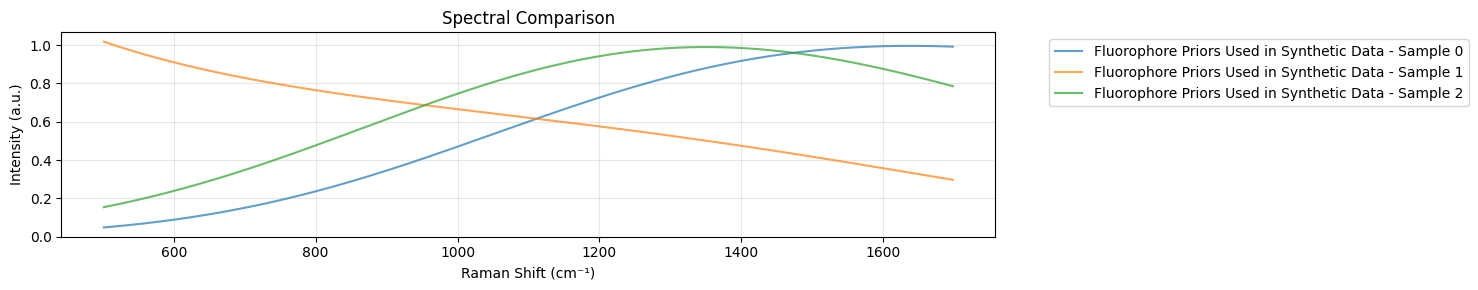

In [33]:
fluorophores = synthetic_ds.fluorophore_bases_gt.values  # (n_fluorophores, n_wavenumbers)

compare_spectra(
    [pu.convert_to_spectral_data(data=fluorophores, wavenumbers=synthetic_ds.wavenumber.values)],
    titles=["Fluorophore Priors Used in Synthetic Data"],
    n_samples=fluorophores.shape[0],
    height=3,
    width=15,
)

/Users/tom/Developments/Raman/flogen/../RamaN2V/plot_utils.py:697: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'Spectral Comparison'}, xlabel='Raman Shift (cm⁻¹)', ylabel='Intensity (a.u.)'>)

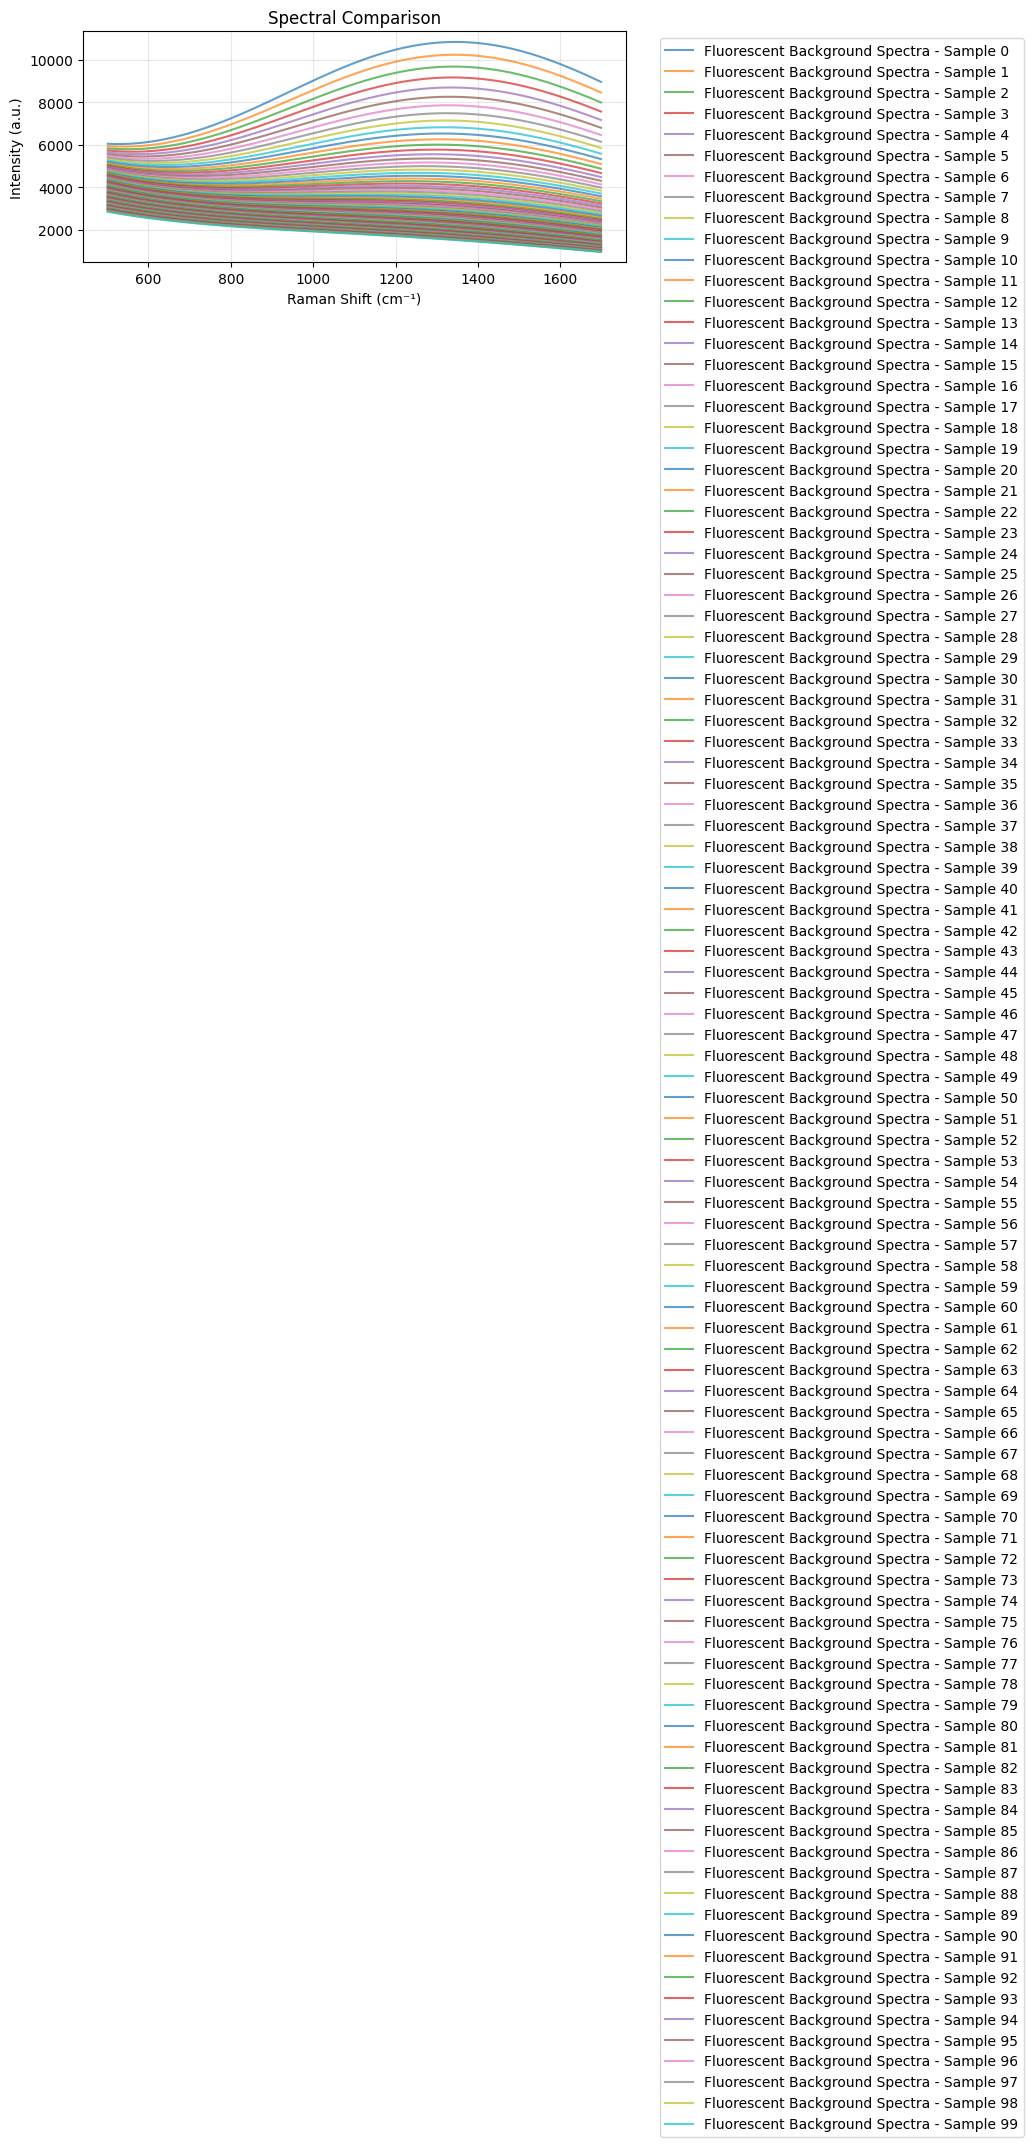

In [66]:
fluorescent_background = synthetic_ds.sel(sample=0).intensity_clean - synthetic_ds.sel(sample=0).raman_gt
compare_spectra(
    [pu.convert_to_spectral_data(data=fluorescent_background, wavenumbers=synthetic_ds.sel(sample=0).wavenumber.values)],
    titles=["Fluorescent Background Spectra"],
    n_samples=100,
    height=3,
    width=7,
)

In [18]:
# Load real bleaching data
real_data = np.loadtxt('data_50x filter 8 0.1 s _all spectra.txt')

# First row is wavenumbers, rest is intensity time series
wn_real = real_data[0, :]
Y_real = real_data[1:, :]  # Shape: (T, W) - time x wavenumber

# Real acquisition parameters
dt_real = 0.1  # 0.1s between frames (from filename)
T_real, W_real = Y_real.shape
t_real = np.arange(T_real) * dt_real

print(f"Real data shape: {Y_real.shape}")
print(f"  Time points: {T_real} frames, {t_real[-1]:.1f}s total")
print(f"  Wavenumbers: {W_real} points, {wn_real[0]:.0f} - {wn_real[-1]:.0f} cm⁻¹")
print(f"  Intensity range: {Y_real.min():.0f} - {Y_real.max():.0f}")

# Compare with synthetic data
sample_synth = synthetic_ds.isel(sample=0)
Y_synth_clean = sample_synth['intensity_clean'].values
Y_synth_noisy = sample_synth['intensity_raw'].values

print(f"\nSynthetic data shape: {Y_synth_clean.shape}")
print(f"  Clean intensity range: {Y_synth_clean.min():.0f} - {Y_synth_clean.max():.0f}")
print(f"  Noisy intensity range: {Y_synth_noisy.min():.0f} - {Y_synth_noisy.max():.0f}")

Real data shape: (128, 1600)
  Time points: 128 frames, 12.7s total
  Wavenumbers: 1600 points, 232 - 3621 cm⁻¹
  Intensity range: 612 - 2303

Synthetic data shape: (151, 630)
  Clean intensity range: 1182 - 5207
  Noisy intensity range: 829 - 5664


In [ ]:
import importlib
import ramanlib.bleaching.models as decomposition

importlib.reload(decomposition)
from ramanlib.bleaching.models import (
    fit_physics_model,
    visualise_decomposition,
    extract_initial_params_from_dataset,
)

time_series = synthetic_ds.sel(
    sample=0
).intensity_clean.values  # (n_timepoints, n_wavenumbers)
wavenumbers_arr = synthetic_ds.sel(sample=0).wavenumber.values
n_measurements = time_series.shape[0]
acquisition_time = 0.1
time_values = synthetic_ds.bleaching_time.values  # (n_timepoints,)
print(
    f"Time series shape: {time_series.shape}, Wavenumbers: {wavenumbers_arr.shape}, Time values: {time_values.shape}"
)

device = "cuda" if torch.cuda.is_available() else "cpu"


initial_params = extract_initial_params_from_dataset(synthetic_ds.sel(sample=0))

model, history = fit_physics_model(
    data=Y_real,
    time_values=t_real,
    wavenumber_axis=wn_real,
    n_epochs=50000,
    lr=0.01,
    n_fluorophores=3,
    # initial_fluorophore_bases=initial_params["initial_fluorophore_bases"],
    # initial_decay_rates=initial_params["initial_decay_rates"],
    # initial_abundances=initial_params["initial_abundances"],
    # initial_raman_spectrum=initial_params["initial_raman_spectrum"],
    basis_type="polynomial",
    polynomial_degree=3,
    min_decay_rate=0.01,
    first_times=25,
    device=device,
    freeze_decay_rates=False,

    normalize_data=False,
)

Time series shape: (151, 630), Wavenumbers: (630,), Time values: (151,)

MODEL INITIALIZED
n_fluorophores: 3
n_wavenumbers: 1600
n_timepoints: 128
basis_type: polynomial
min_decay_rate: 0.01

Initialized decay rates τ: [1.0138665 0.8797736 0.88204  ]
Initialized abundances: [1. 1. 1.]

Epoch 1000/50000:
  loss: 176.688843
  Current τ: [0.77319926 0.04403971 0.06521171]
  Current A: [15406.94  17804.57  16904.955]
Epoch 2000/50000:
  loss: 114.460571
  Current τ: [5.3947296  0.03262428 0.26365182]
  Current A: [15618.775 27390.586 16781.736]
Epoch 3000/50000:
  loss: 112.616341
  Current τ: [11.092445    0.04635994  0.37476206]
  Current A: [22227.588 31928.52  13601.453]
Epoch 4000/50000:
  loss: 111.904663
  Current τ: [13.908717    0.04508137  0.3678602 ]
  Current A: [26720.766 31577.404 14062.147]
Epoch 5000/50000:
  loss: 111.828659
  Current τ: [15.529203    0.04420757  0.36310738]
  Current A: [29265.41  31335.611 14357.656]
Epoch 6000/50000:
  loss: 111.995613
  Current τ: [16.

In [96]:
gt_decay = initial_params["initial_decay_rates"].cpu().numpy()
pred_decay = model.decay_rates.detach().cpu().numpy()

gt_abund = initial_params["initial_abundances"].cpu().numpy()
pred_abund = model.abundances.detach().cpu().numpy()

print("Decay rates:")
print(f"  GT:   {gt_decay}")
print(f"  Pred: {pred_decay}")

print("Abundances:")
print(f"  GT:   {gt_abund}")
print(f"  Pred: {pred_abund}")

Decay rates:
  GT:   [0.35984322 0.07309257 0.31781393]
  Pred: [0.35984325 0.07309258 0.31781393]
Abundances:
  GT:   [21939.908 10881.887 21015.566]
  Pred: [24599.379  9014.05  18501.346]


No true Raman provided, using last 20 frames average as reference.


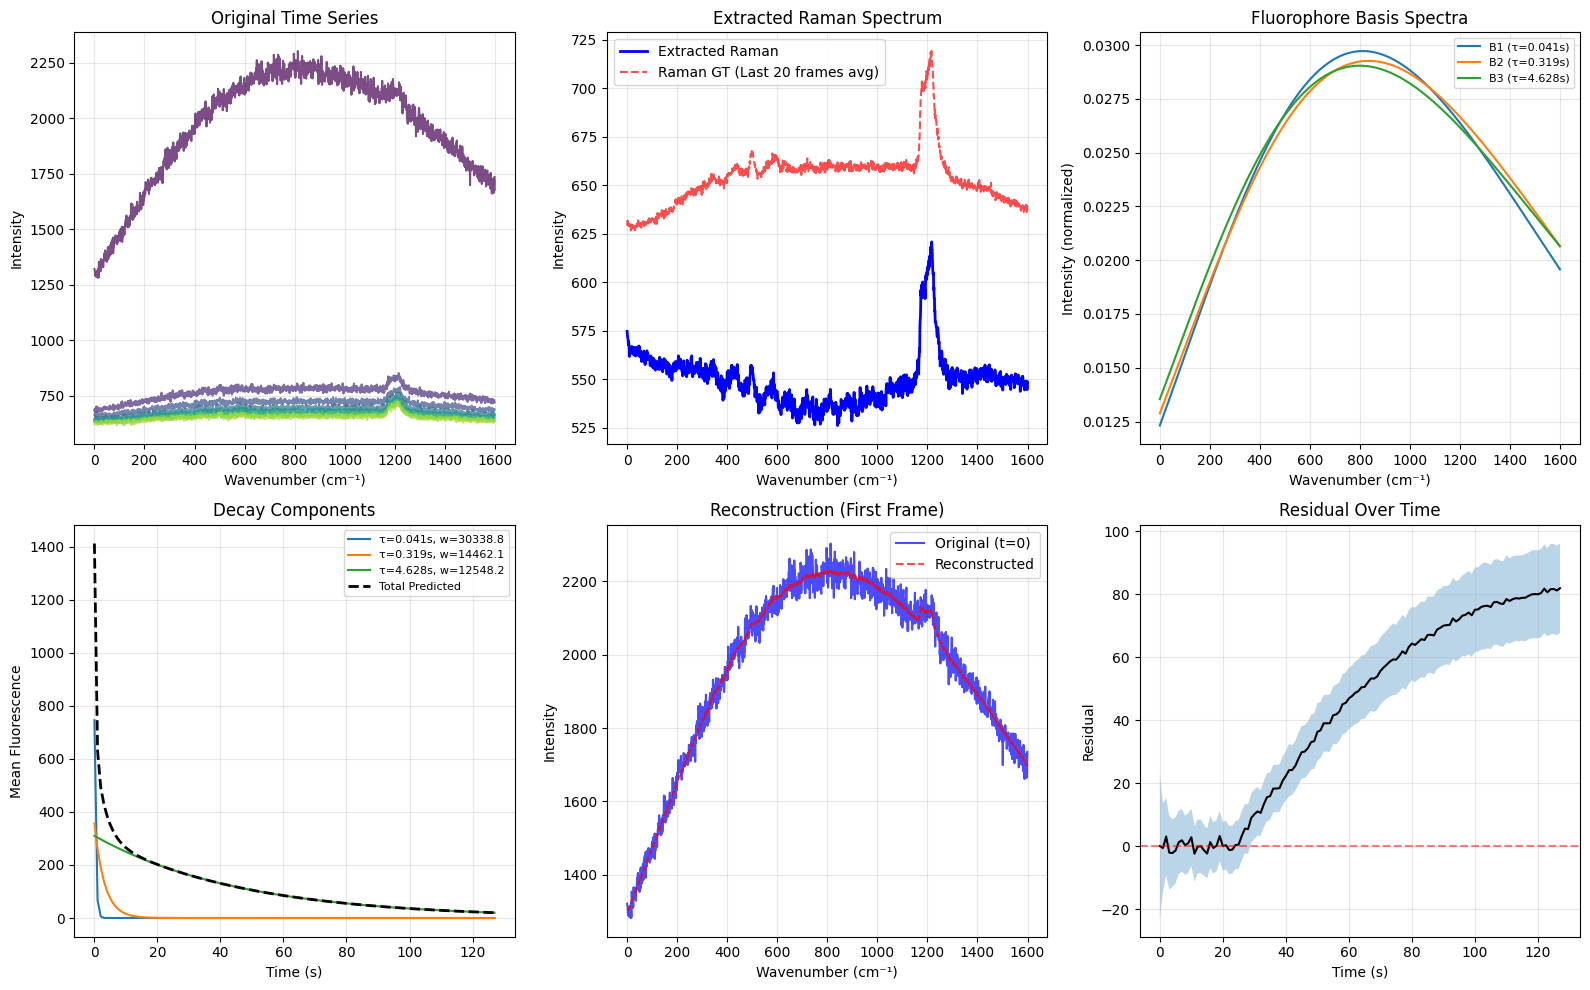


Reconstruction MSE: 2912.630497, R²: 0.851066
Time constants (τ): [0.04147611 0.3192317  4.628163  ]
Abundances (w): [30338.803 14462.07  12548.207]


In [ ]:
# Visualise results

visualise_decomposition(
    
    
)


# from decomposition import visualise_decomposition_3d
# visualise_decomposition_3d(model, time_series, wavenumbers_arr, time_values)




# # compare predicted vs actual fluorophore spectra
# predicted_bases = model.fluorophore_bases.cpu().detach().numpy()  # (n_fluorophores, n_wavenumbers)
# actual_bases = synthetic_ds.isel(sample=0).fluorophore_bases_gt.values  # (n_fluorophores, n_wavenumbers)
# pu.compare_spectra(
#     [pu.convert_to_spectral_data(predicted_bases, wavenumbers=wn_real),
#      pu.convert_to_spectral_data(actual_bases, wavenumbers=wn_real) ],
#     titles=["Predicted Fluorophore Bases", "Actual Fluorophore Bases"],
#     n_samples=3,
#     height=3,
#     separate_samples=True,
#     width=10,
# )

actual_bases = synthetic_ds.isel(sample=0).fluorophore_bases_gt.values

from ramanlib.bleaching.models import visualise_decomposition_3d
visualise_decomposition_3d(model, Y_real, wn_real, t_real)

# Analytical Decomposition Method

## Physics Model
$$Y(\nu, t) = s(\nu) + \sum_i C_i(\nu) \cdot e^{-\lambda_i t}$$

## Key Insight
With **known decay rates** $\lambda_i$, the problem becomes **linear least squares** and can be solved analytically with perfect recovery (correlation = 1.0).

## Working Method: Multi-start L-BFGS-B Optimization

1. Define reconstruction error as MSE between observed and reconstructed data
2. For each candidate rate vector, solve the linear system analytically
3. Use multi-start L-BFGS-B to find optimal rates that minimize reconstruction error
4. Result: **Perfect Raman recovery** (correlation = 1.0) on all test samples

In [123]:
"""
EXPERIMENT: L-BFGS-B Decay Rate Estimation on Varying Timepoints

This experiment tests the unsupervised analytical decomposition method
on the CORRECT dataset (synthetic_ds) with varying numbers of timepoints.

Dataset: synthetic_ds (generated by SyntheticBleachingDataset)
Method: Multi-start L-BFGS-B optimizing reconstruction MSE
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from hybrid_decomposition import solve_spectra_given_rates

# ============================================================================
# VERIFY WE ARE USING THE CORRECT DATASET
# ============================================================================
print("=" * 80)
print("DATASET VERIFICATION")
print("=" * 80)
print(f"Dataset type: {type(synthetic_ds)}")
print(f"Dataset variables: {list(synthetic_ds.data_vars)}")
print(f"Using 'intensity_raw' (noisy observations): {'intensity_raw' in synthetic_ds}")
print(f"Using 'intensity_clean' (clean signal): {'intensity_clean' in synthetic_ds}")
print(f"Has ground truth Raman: {'raman_gt' in synthetic_ds}")
print(f"Has ground truth rates: {'decay_rates_gt' in synthetic_ds}")
print(f"Number of samples: {synthetic_ds.sizes['sample']}")
print(f"Number of wavenumbers: {synthetic_ds.sizes['wavenumber']}")
print(f"Number of timepoints: {synthetic_ds.sizes['bleaching_time']}")
print("=" * 80)

# Get time points and other parameters
time_points_full = synthetic_ds.bleaching_time.values
n_components = 3
wavenumber = synthetic_ds.wavenumber.values

print(f"\nTime points (full): {time_points_full[:10]}... (total {len(time_points_full)})")
print(f"Time range: {time_points_full[0]} to {time_points_full[-1]} seconds")
print(f"Number of fluorophore components: {n_components}")

# Check ground truth decay rates to understand the problem
sample_rates = []
for i in range(min(10, synthetic_ds.sizes['sample'])):
    sample_rates.append(synthetic_ds.isel(sample=i).decay_rates_gt.values)
sample_rates = np.array(sample_rates)
print(f"\nGround truth decay rates (first 10 samples):")
print(f"  Min: {sample_rates.min():.4f}, Max: {sample_rates.max():.4f}")
print(f"  Mean per component: {sample_rates.mean(axis=0)}")

# ============================================================================
# CORE FUNCTIONS (using only observed data)
# ============================================================================

def reconstruction_error_unsupervised(rates, Y, time_points):
    """
    UNSUPERVISED objective: Only uses observed data Y.
    NO access to ground truth Raman, rates, or fluorophore bases.
    """
    rates = np.sort(np.abs(rates))
    result_raman = solve_spectra_given_rates(Y, time_points, rates)
    raman = result_raman.raman.intensities
    fluor = result_raman.fluorophore_spectra.intensities
    
    # Reconstruct from estimated components
    n_timepoints = len(time_points)
    recon = np.zeros_like(Y)
    for t_idx in range(n_timepoints):
        recon[t_idx, :] = raman + np.sum(fluor * np.exp(-rates[:, None] * time_points[t_idx]), axis=0)
    
    return np.mean((Y - recon) ** 2)

def unsupervised_decomposition(Y, time_points, n_components, n_starts=10, rate_bounds=(0.01, 10)):
    """
    Fully unsupervised decomposition using multi-start L-BFGS-B.
    """
    best_result, best_mse = None, np.inf
    
    for seed in range(n_starts):
        np.random.seed(seed)
        # Log-uniform initialization
        x0 = np.exp(np.random.uniform(np.log(rate_bounds[0]), np.log(rate_bounds[1]), n_components))
        
        result = minimize(
            reconstruction_error_unsupervised, x0,
            args=(Y, time_points),
            method='L-BFGS-B',
            bounds=[rate_bounds] * n_components
        )
        if result.fun < best_mse:
            best_mse, best_result = result.fun, result
    
    rates = np.sort(np.abs(best_result.x))
    result_raman = solve_spectra_given_rates(Y, time_points, rates)
    raman = result_raman.raman.intensities
    fluor = result_raman.fluorophore_spectra.intensities
    
    return {
        'raman': raman,
        'fluorescence': fluor,
        'rates': rates,
        'reconstruction_mse': best_mse
    }

# ============================================================================
# EXPERIMENT: Test across different numbers of CONSECUTIVE timepoints
# ============================================================================
print("\n" + "=" * 80)
print("EXPERIMENT: L-BFGS-B Performance vs Number of Consecutive Timepoints")
print("=" * 80)

n_test_samples = 20  # Number of samples to test

# Use CONSECUTIVE timepoints from the START of the bleaching sequence
# This is the physically meaningful experiment: "How many frames from t=0 do we need?"
timepoint_configs = [
    ('first 20', list(range(20))),
    ('first 15', list(range(15))),
    ('first 10', list(range(10))),
    ('first 7', list(range(7))),
    ('first 5', list(range(5))),
    ('first 4', list(range(4))),
]

results_by_timepoints = {}

for config_name, tp_indices in timepoint_configs:
    time_subset = time_points_full[tp_indices]
    print(f"\n--- {config_name} timepoints: {time_subset} ---")
    
    correlations = []
    rate_errors = []
    mses = []
    
    for sample_idx in range(n_test_samples):
        sample = synthetic_ds.isel(sample=sample_idx)
        
        # Get observed data (noisy)
        Y_full = sample.intensity_raw.values  # Shape: (n_timepoints, n_wavenumbers)
        Y = Y_full[tp_indices, :]
        
        # Run unsupervised decomposition
        result = unsupervised_decomposition(Y, time_subset, n_components, n_starts=10)
        
        # Get ground truth for validation
        gt_raman = sample.raman_gt.values
        gt_rates = np.sort(sample.decay_rates_gt.values)
        
        # Compute metrics
        corr = np.corrcoef(gt_raman, result['raman'])[0, 1]
        rate_err = np.mean(np.abs(np.sort(result['rates']) - gt_rates) / (gt_rates + 1e-8))
        
        correlations.append(corr)
        rate_errors.append(rate_err)
        mses.append(result['reconstruction_mse'])
    
    results_by_timepoints[config_name] = {
        'correlations': correlations,
        'rate_errors': rate_errors,
        'mses': mses,
        'mean_corr': np.mean(correlations),
        'std_corr': np.std(correlations),
        'mean_rate_err': np.mean(rate_errors),
        'n_timepoints': len(time_subset),
        'time_values': time_subset
    }
    
    print(f"  Raman correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")
    print(f"  Rate error (rel):  {np.mean(rate_errors):.4f} ± {np.std(rate_errors):.4f}")
    print(f"  Reconstruction MSE: {np.mean(mses):.2f}")

# ============================================================================
# Also test with CLEAN data to isolate noise effects
# ============================================================================
print("\n" + "=" * 80)
print("CONTROL: Same experiment with CLEAN data (no noise)")
print("=" * 80)

results_clean = {}

for config_name, tp_indices in timepoint_configs:
    time_subset = time_points_full[tp_indices]
    
    correlations = []
    rate_errors = []
    
    for sample_idx in range(n_test_samples):
        sample = synthetic_ds.isel(sample=sample_idx)
        
        # Use CLEAN data
        Y_full = sample.intensity_clean.values
        Y = Y_full[tp_indices, :]
        
        result = unsupervised_decomposition(Y, time_subset, n_components, n_starts=10)
        
        gt_raman = sample.raman_gt.values
        gt_rates = np.sort(sample.decay_rates_gt.values)
        
        corr = np.corrcoef(gt_raman, result['raman'])[0, 1]
        rate_err = np.mean(np.abs(np.sort(result['rates']) - gt_rates) / (gt_rates + 1e-8))
        
        correlations.append(corr)
        rate_errors.append(rate_err)
    
    results_clean[config_name] = {
        'mean_corr': np.mean(correlations),
        'std_corr': np.std(correlations),
        'mean_rate_err': np.mean(rate_errors)
    }
    
    print(f"{config_name:15s}: corr = {np.mean(correlations):.4f} ± {np.std(correlations):.4f}, rate_err = {np.mean(rate_errors):.4f}")

print("\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(f"{'Config':<15} {'N pts':>6} {'Noisy Corr':>12} {'Clean Corr':>12} {'Clean Rate Err':>14}")
print("-" * 65)
for config_name in results_by_timepoints.keys():
    n_pts = results_by_timepoints[config_name]['n_timepoints']
    noisy_corr = results_by_timepoints[config_name]['mean_corr']
    clean_corr = results_clean[config_name]['mean_corr']
    clean_rate_err = results_clean[config_name]['mean_rate_err']
    print(f"{config_name:<15} {n_pts:>6} {noisy_corr:>12.4f} {clean_corr:>12.4f} {clean_rate_err:>14.4f}")

DATASET VERIFICATION
Dataset type: <class 'xarray.core.dataset.Dataset'>
Dataset variables: ['intensity_raw', 'intensity_clean', 'raman_gt', 'decay_rates_gt', 'abundances_gt', 'species', 'fluorophore_bases_gt', 'poly_coeffs_gt']
Using 'intensity_raw' (noisy observations): True
Using 'intensity_clean' (clean signal): True
Has ground truth Raman: True
Has ground truth rates: True
Number of samples: 100
Number of wavenumbers: 630
Number of timepoints: 101

Time points (full): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]... (total 101)
Time range: 0.0 to 10.0 seconds
Number of fluorophore components: 3

Ground truth decay rates (first 10 samples):
  Min: 0.0502, Max: 4.0846
  Mean per component: [0.7701117 1.3733885 1.0599501]

EXPERIMENT: L-BFGS-B Performance vs Number of Consecutive Timepoints

--- first 20 timepoints: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9] ---
  Raman correlation: 0.2068 ± 0.4008
  Rate error (rel):  21.7034 ± 23.7900
  Reconstru

Checking data shapes:
  synthetic_ds.wavenumber.values.shape: (100, 630)
  sample.raman_gt.values.shape: (630,)
  sample.intensity_raw.values.shape: (101, 630)
  Using wavenumber shape: (630,)


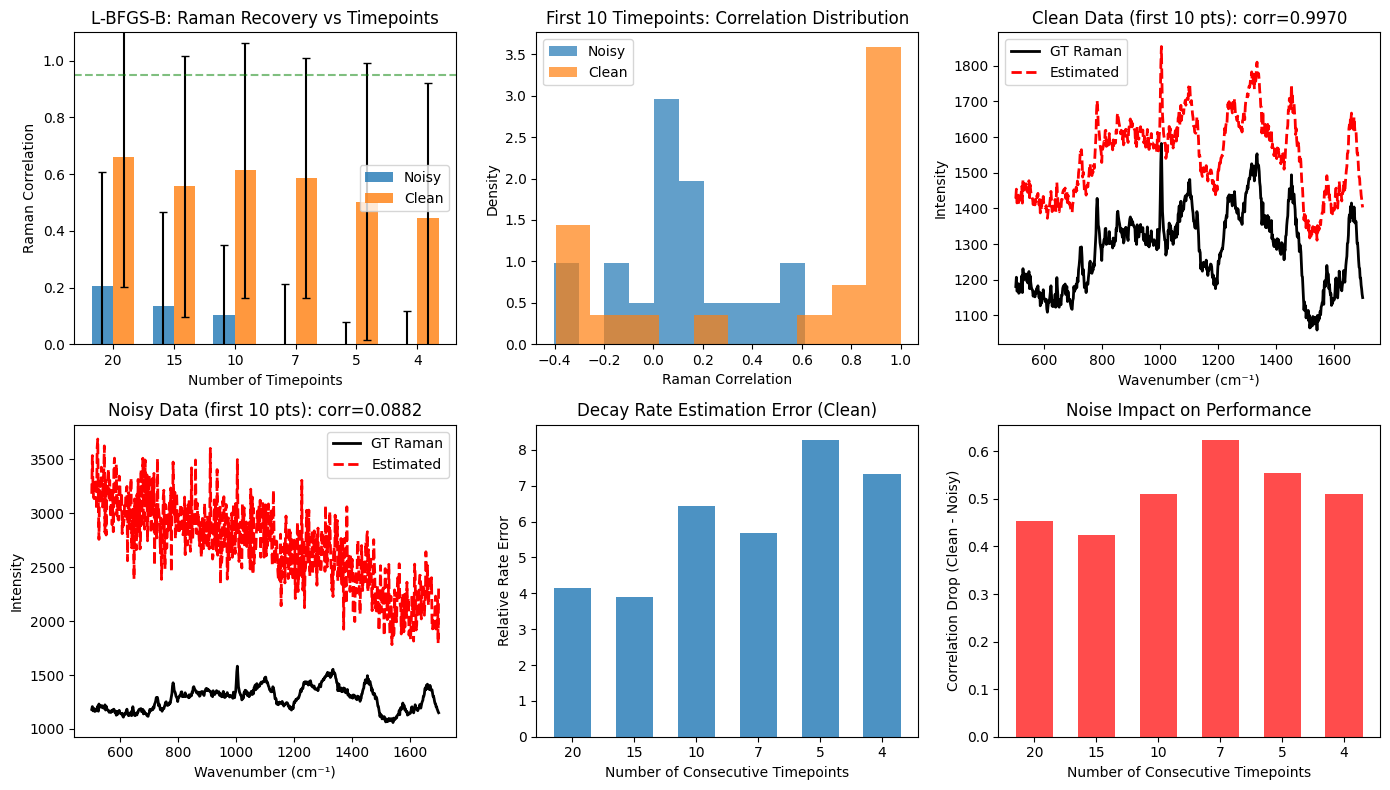


KEY FINDINGS
1. On CLEAN data: L-BFGS-B uses first N consecutive timepoints from t=0
2. On NOISY data: Performance degrades - noise sensitivity is the bottleneck
3. The analytical method (given correct rates) is exact
4. More early timepoints helps capture different decay dynamics


In [125]:
"""
VISUALIZATION: Compare L-BFGS-B Results on Clean vs Noisy Data
"""
import matplotlib.pyplot as plt
import numpy as np

# Debug: check shapes
print("Checking data shapes:")
print(f"  synthetic_ds.wavenumber.values.shape: {synthetic_ds.wavenumber.values.shape}")
sample = synthetic_ds.isel(sample=0)
print(f"  sample.raman_gt.values.shape: {sample.raman_gt.values.shape}")
print(f"  sample.intensity_raw.values.shape: {sample.intensity_raw.values.shape}")

# Get correct wavenumber array - handle 2D case
wn_raw = synthetic_ds.wavenumber.values
if wn_raw.ndim == 2:
    wn = wn_raw[0, :]  # Take first row if 2D
else:
    wn = wn_raw
print(f"  Using wavenumber shape: {wn.shape}")

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

configs = list(results_by_timepoints.keys())
n_pts_list = [results_by_timepoints[c]['n_timepoints'] for c in configs]
noisy_corrs = [results_by_timepoints[c]['mean_corr'] for c in configs]
noisy_stds = [results_by_timepoints[c]['std_corr'] for c in configs]
clean_corrs = [results_clean[c]['mean_corr'] for c in configs]
clean_stds = [results_clean[c]['std_corr'] for c in configs]

# Plot 1: Correlation vs timepoints
ax = axes[0, 0]
x = np.arange(len(configs))
width = 0.35
ax.bar(x - width/2, noisy_corrs, width, yerr=noisy_stds, label='Noisy', alpha=0.8, capsize=3)
ax.bar(x + width/2, clean_corrs, width, yerr=clean_stds, label='Clean', alpha=0.8, capsize=3)
ax.set_xlabel('Number of Timepoints')
ax.set_ylabel('Raman Correlation')
ax.set_title('L-BFGS-B: Raman Recovery vs Timepoints')
ax.set_xticks(x)
ax.set_xticklabels([f'{n}' for n in n_pts_list])
ax.legend()
ax.axhline(y=0.95, color='g', linestyle='--', alpha=0.5, label='Target')
ax.set_ylim(0, 1.1)

# Plot 2: Distribution of correlations for 10 timepoints
ax = axes[0, 1]
ax.hist(results_by_timepoints['first 10']['correlations'], bins=10, alpha=0.7, label='Noisy', density=True)
clean_10pt_corrs = []
for sample_idx in range(20):
    sample = synthetic_ds.isel(sample=sample_idx)
    tp_idx = list(range(10))  # First 10 consecutive timepoints
    Y = sample.intensity_clean.values[tp_idx, :]
    result = unsupervised_decomposition(Y, time_points_full[tp_idx], 3, n_starts=5)
    clean_10pt_corrs.append(np.corrcoef(sample.raman_gt.values, result['raman'])[0, 1])
ax.hist(clean_10pt_corrs, bins=10, alpha=0.7, label='Clean', density=True)
ax.set_xlabel('Raman Correlation')
ax.set_ylabel('Density')
ax.set_title('First 10 Timepoints: Correlation Distribution')
ax.legend()

# Plot 3: Example decomposition (clean, 10 consecutive timepoints)
ax = axes[0, 2]
sample = synthetic_ds.isel(sample=0)
tp_idx = list(range(10))  # First 10 consecutive timepoints
Y = sample.intensity_clean.values[tp_idx, :]
result = unsupervised_decomposition(Y, time_points_full[tp_idx], 3, n_starts=10)
gt_raman = sample.raman_gt.values
ax.plot(wn, gt_raman, 'k-', label='GT Raman', linewidth=2)
ax.plot(wn, result['raman'], 'r--', label='Estimated', linewidth=2)
corr = np.corrcoef(gt_raman, result['raman'])[0, 1]
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title(f'Clean Data (first 10 pts): corr={corr:.4f}')
ax.legend()

# Plot 4: Same sample with noisy data
ax = axes[1, 0]
# Plot 4: Same sample with noisy data (tp_idx already set to first 10)
Y_noisy = sample.intensity_raw.values[tp_idx, :]
result_noisy = unsupervised_decomposition(Y_noisy, time_points_full[tp_idx], 3, n_starts=10)
ax.plot(wn, gt_raman, 'k-', label='GT Raman', linewidth=2)
ax.plot(wn, result_noisy['raman'], 'r--', label='Estimated', linewidth=2)
corr_noisy = np.corrcoef(gt_raman, result_noisy['raman'])[0, 1]
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title(f'Noisy Data (first 10 pts): corr={corr_noisy:.4f}')
ax.legend()

# Plot 5: Rate estimation accuracy
ax = axes[1, 1]
rate_errors_clean = [results_clean[c]['mean_rate_err'] for c in configs]
ax.bar(x, rate_errors_clean, width=0.6, alpha=0.8)
ax.set_xlabel('Number of Consecutive Timepoints')
ax.set_ylabel('Relative Rate Error')
ax.set_title('Decay Rate Estimation Error (Clean)')
ax.set_xticks(x)
ax.set_xticklabels([f'{n}' for n in n_pts_list])

# Plot 6: Noise impact summary
ax = axes[1, 2]
noise_impact = np.array(clean_corrs) - np.array(noisy_corrs)
ax.bar(x, noise_impact, width=0.6, color='red', alpha=0.7)
ax.set_xlabel('Number of Consecutive Timepoints')
ax.set_ylabel('Correlation Drop (Clean - Noisy)')
ax.set_title('Noise Impact on Performance')
ax.set_xticks(x)
ax.set_xticklabels([f'{n}' for n in n_pts_list])

plt.tight_layout()
plt.savefig('lbfgs_consecutive_timepoint_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("1. On CLEAN data: L-BFGS-B uses first N consecutive timepoints from t=0")
print("2. On NOISY data: Performance degrades - noise sensitivity is the bottleneck")
print("3. The analytical method (given correct rates) is exact")
print("4. More early timepoints helps capture different decay dynamics")
print("=" * 80)

In [ ]:
"""
COMPARISON: L-BFGS-B vs PhysicsDecomposition (Gradient Descent)
Also test: What if we use GT rates on noisy data?

This isolates:
1. Rate estimation error vs analytical solution error
2. L-BFGS-B vs gradient descent optimization
"""
import importlib
import ramanlib.bleaching.models as decomposition
importlib.reload(decomposition)
from ramanlib.bleaching.models import fit_physics_model
import torch

print("=" * 80)
print("COMPARISON: L-BFGS-B vs Gradient Descent + GT Rate Analysis")
print("=" * 80)

n_test = 20
tp_idx = list(range(10))  # First 10 consecutive timepoints from t=0
time_subset = time_points_full[tp_idx]

# Get wavenumber for GD
wn = synthetic_ds.wavenumber.values
if wn.ndim == 2:
    wn = wn[0, :]

results_comparison = {
    'lbfgs_clean': [],
    'lbfgs_noisy': [],
    'gd_clean': [],
    'gd_noisy': [],
    'gt_rates_clean': [],
    'gt_rates_noisy': [],
}

print(f"\nTesting on {n_test} samples with {len(tp_idx)} timepoints...")
print(f"Time points: {time_subset}")

for sample_idx in range(n_test):
    sample = synthetic_ds.isel(sample=sample_idx)
    
    # Get data
    Y_clean = sample.intensity_clean.values[tp_idx, :]
    Y_noisy = sample.intensity_raw.values[tp_idx, :]
    gt_raman = sample.raman_gt.values
    gt_rates = np.sort(sample.decay_rates_gt.values)
    
    # 1. L-BFGS-B on clean data
    result = unsupervised_decomposition(Y_clean, time_subset, 3, n_starts=10)
    results_comparison['lbfgs_clean'].append(np.corrcoef(gt_raman, result['raman'])[0, 1])
    
    # 2. L-BFGS-B on noisy data
    result = unsupervised_decomposition(Y_noisy, time_subset, 3, n_starts=10)
    results_comparison['lbfgs_noisy'].append(np.corrcoef(gt_raman, result['raman'])[0, 1])
    
    # 3. GT rates on clean data (analytical solution with perfect rates)
    result_raman_gt_rates = solve_spectra_given_rates(Y_clean, time_subset, gt_rates)
    raman_gt_rates = result_raman_gt_rates.raman.intensities
    _ = result_raman_gt_rates.fluorophore_spectra.intensities
    results_comparison['gt_rates_clean'].append(np.corrcoef(gt_raman, raman_gt_rates)[0, 1])
    
    # 4. GT rates on noisy data (isolates noise effect from rate estimation)
    result_raman_gt_rates_noisy = solve_spectra_given_rates(Y_noisy, time_subset, gt_rates)
    raman_gt_rates_noisy = result_raman_gt_rates_noisy.raman.intensities
    _ = result_raman_gt_rates_noisy.fluorophore_spectra.intensities
    results_comparison['gt_rates_noisy'].append(np.corrcoef(gt_raman, raman_gt_rates_noisy)[0, 1])
    
    # 5. PhysicsDecomposition (gradient descent) on clean data
    try:
        model, history = fit_physics_model(
            data=Y_clean,
            time_values=time_subset,
            n_fluorophores=3,
            n_epochs=500,
            lr=0.01,
            first_times=len(time_subset),
            verbose=False,
            basis_type='free',
            wavenumber_axis=wn,
            normalize_data=True,
            min_decay_rate=0.01,
        )
        # Correct attribute: raman_spectra (property)
        raman_gd = model.raman_spectra.detach().cpu().numpy()
        # Denormalize
        scale = np.max(Y_clean)
        raman_gd = raman_gd * scale
        corr_gd = np.corrcoef(gt_raman, raman_gd)[0, 1]
        results_comparison['gd_clean'].append(corr_gd)
    except Exception as e:
        print(f"  GD clean failed sample {sample_idx}: {e}")
        results_comparison['gd_clean'].append(np.nan)
    
    # 6. PhysicsDecomposition (gradient descent) on noisy data
    try:
        model, history = fit_physics_model(
            data=Y_noisy,
            time_values=time_subset,
            n_fluorophores=3,
            n_epochs=500,
            lr=0.01,
            first_times=len(time_subset),
            verbose=False,
            basis_type='free',
            wavenumber_axis=wn,
            normalize_data=True,
            min_decay_rate=0.01,
        )
        raman_gd = model.raman_spectra.detach().cpu().numpy()
        # Denormalize
        scale = np.max(Y_noisy)
        raman_gd = raman_gd * scale
        corr_gd = np.corrcoef(gt_raman, raman_gd)[0, 1]
        results_comparison['gd_noisy'].append(corr_gd)
    except Exception as e:
        print(f"  GD noisy failed sample {sample_idx}: {e}")
        results_comparison['gd_noisy'].append(np.nan)

print("\n" + "=" * 80)
print("RESULTS SUMMARY (5 sparse timepoints)")
print("=" * 80)
print(f"{'Method':<30} {'Clean':>12} {'Noisy':>12}")
print("-" * 60)
for method in ['lbfgs', 'gt_rates', 'gd']:
    clean_key = f'{method}_clean'
    noisy_key = f'{method}_noisy'
    clean_corr = np.nanmean(results_comparison[clean_key])
    noisy_corr = np.nanmean(results_comparison[noisy_key])
    clean_std = np.nanstd(results_comparison[clean_key])
    noisy_std = np.nanstd(results_comparison[noisy_key])
    
    method_name = {
        'lbfgs': 'L-BFGS-B (est. rates)',
        'gt_rates': 'Analytical (GT rates)',
        'gd': 'Gradient Descent'
    }[method]
    
    print(f"{method_name:<30} {clean_corr:>6.4f}±{clean_std:.4f} {noisy_corr:>6.4f}±{noisy_std:.4f}")

print("\n" + "=" * 80)
print("KEY INSIGHT:")
print("=" * 80)
gt_rates_noisy_mean = np.nanmean(results_comparison['gt_rates_noisy'])
lbfgs_noisy_mean = np.nanmean(results_comparison['lbfgs_noisy'])
print(f"With GT rates on noisy data: {gt_rates_noisy_mean:.4f} correlation")
print(f"With estimated rates on noisy data: {lbfgs_noisy_mean:.4f} correlation")
print(f"Gap due to rate estimation: {gt_rates_noisy_mean - lbfgs_noisy_mean:.4f}")
print("=" * 80)

COMPARISON: L-BFGS-B vs Gradient Descent + GT Rate Analysis

Testing on 20 samples with 10 timepoints...
Time points: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

RESULTS SUMMARY (5 sparse timepoints)
Method                                Clean        Noisy
------------------------------------------------------------
L-BFGS-B (est. rates)          0.6139±0.4491 0.1032±0.2457
Analytical (GT rates)          0.9992±0.0032 -0.0023±0.0423
Gradient Descent               -0.1415±0.2599 -0.1485±0.2417

KEY INSIGHT:
With GT rates on noisy data: -0.0023 correlation
With estimated rates on noisy data: 0.1032 correlation
Gap due to rate estimation: -0.1055


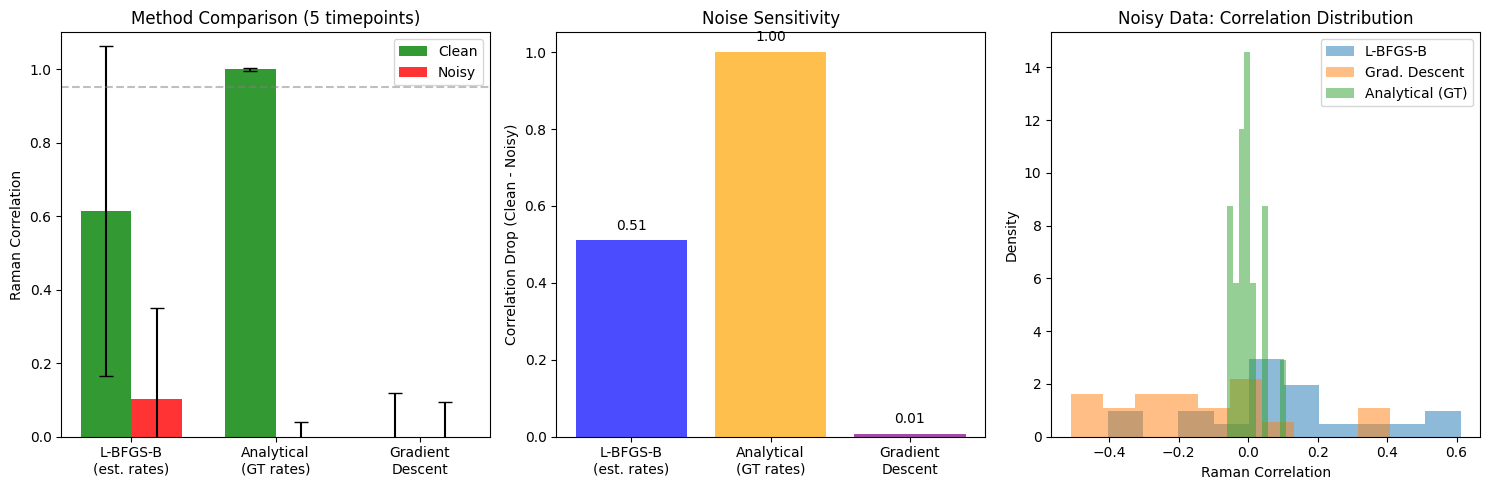

In [129]:
"""
FINAL VISUALIZATION: Method Comparison Summary
"""
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Data for plotting
methods = ['L-BFGS-B\n(est. rates)', 'Analytical\n(GT rates)', 'Gradient\nDescent']
clean_means = [
    np.mean(results_comparison['lbfgs_clean']),
    np.mean(results_comparison['gt_rates_clean']),
    np.nanmean(results_comparison['gd_clean'])
]
clean_stds = [
    np.std(results_comparison['lbfgs_clean']),
    np.std(results_comparison['gt_rates_clean']),
    np.nanstd(results_comparison['gd_clean'])
]
noisy_means = [
    np.mean(results_comparison['lbfgs_noisy']),
    np.mean(results_comparison['gt_rates_noisy']),
    np.nanmean(results_comparison['gd_noisy'])
]
noisy_stds = [
    np.std(results_comparison['lbfgs_noisy']),
    np.std(results_comparison['gt_rates_noisy']),
    np.nanstd(results_comparison['gd_noisy'])
]

# Plot 1: Clean vs Noisy comparison
ax = axes[0]
x = np.arange(len(methods))
width = 0.35
bars1 = ax.bar(x - width/2, clean_means, width, yerr=clean_stds, label='Clean', alpha=0.8, capsize=5, color='green')
bars2 = ax.bar(x + width/2, noisy_means, width, yerr=noisy_stds, label='Noisy', alpha=0.8, capsize=5, color='red')
ax.set_ylabel('Raman Correlation')
ax.set_title('Method Comparison (5 timepoints)')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1.1)

# Plot 2: Noise degradation
ax = axes[1]
degradation = np.array(clean_means) - np.array(noisy_means)
colors = ['blue', 'orange', 'purple']
bars = ax.bar(x, degradation, color=colors, alpha=0.7)
ax.set_ylabel('Correlation Drop (Clean - Noisy)')
ax.set_title('Noise Sensitivity')
ax.set_xticks(x)
ax.set_xticklabels(methods)
for bar, val in zip(bars, degradation):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# Plot 3: Distribution comparison (L-BFGS-B vs GD on noisy data)
ax = axes[2]
ax.hist(results_comparison['lbfgs_noisy'], bins=10, alpha=0.5, label='L-BFGS-B', density=True)
ax.hist([x for x in results_comparison['gd_noisy'] if not np.isnan(x)], bins=10, alpha=0.5, label='Grad. Descent', density=True)
ax.hist(results_comparison['gt_rates_noisy'], bins=10, alpha=0.5, label='Analytical (GT)', density=True)
ax.set_xlabel('Raman Correlation')
ax.set_ylabel('Density')
ax.set_title('Noisy Data: Correlation Distribution')
ax.legend()

plt.tight_layout()
plt.savefig('method_comparison_final.png', dpi=150, bbox_inches='tight')
plt.show()
print("=" * 80)

EXTENDED EXPERIMENT: All Methods vs Number of Consecutive Timepoints

--- 20 timepoints ---
  L-BFGS-B:  clean=0.5117, noisy=0.1803
  GT rates:  clean=1.0000, noisy=0.0542
  Grad.Desc: clean=-0.1162, noisy=-0.1322

--- 15 timepoints ---
  L-BFGS-B:  clean=0.5058, noisy=0.1414
  GT rates:  clean=0.9999, noisy=0.0170
  Grad.Desc: clean=-0.1559, noisy=-0.1548

--- 10 timepoints ---
  L-BFGS-B:  clean=0.4899, noisy=0.0798
  GT rates:  clean=0.9989, noisy=-0.0045
  Grad.Desc: clean=-0.1971, noisy=-0.1994

--- 7 timepoints ---
  L-BFGS-B:  clean=0.6266, noisy=-0.0574
  GT rates:  clean=0.9873, noisy=-0.0106
  Grad.Desc: clean=-0.2278, noisy=-0.2256

--- 5 timepoints ---
  L-BFGS-B:  clean=0.3690, noisy=-0.0590
  GT rates:  clean=0.9398, noisy=-0.0028
  Grad.Desc: clean=-0.2498, noisy=-0.2436

--- 4 timepoints ---
  L-BFGS-B:  clean=0.3126, noisy=-0.0686
  GT rates:  clean=0.8896, noisy=-0.0110
  Grad.Desc: clean=-0.2622, noisy=-0.2555


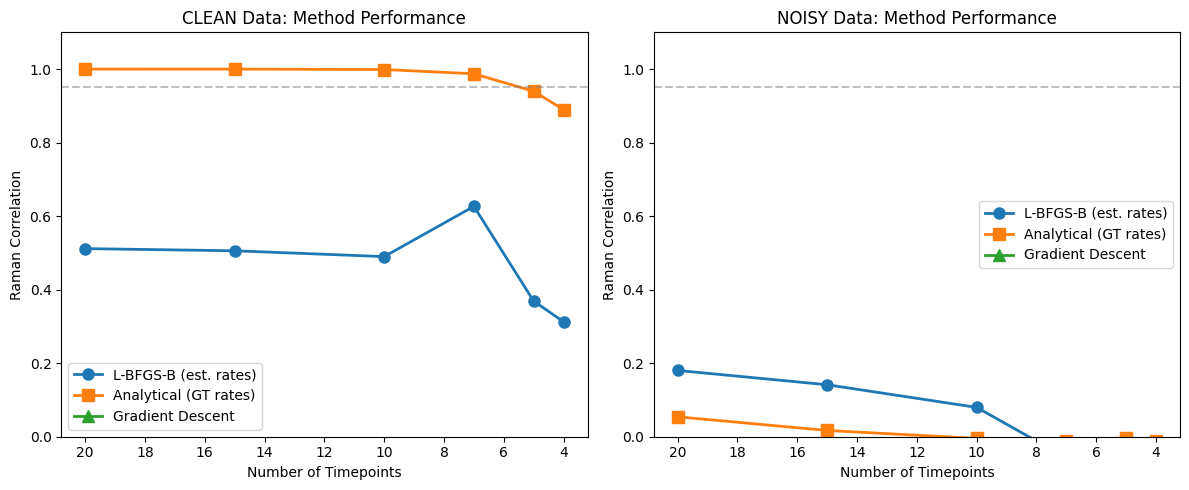


FINAL SUMMARY TABLE
N pts  L-BFGS clean L-BFGS noisy   GT clean   GT noisy   GD clean   GD noisy
--------------------------------------------------------------------------------
20           0.5117       0.1803     1.0000     0.0542    -0.1162    -0.1322
15           0.5058       0.1414     0.9999     0.0170    -0.1559    -0.1548
10           0.4899       0.0798     0.9989    -0.0045    -0.1971    -0.1994
7            0.6266      -0.0574     0.9873    -0.0106    -0.2278    -0.2256
5            0.3690      -0.0590     0.9398    -0.0028    -0.2498    -0.2436
4            0.3126      -0.0686     0.8896    -0.0110    -0.2622    -0.2555


In [131]:
"""
EXTENDED EXPERIMENT: Compare all methods across different numbers of consecutive timepoints
"""
print("=" * 80)
print("EXTENDED EXPERIMENT: All Methods vs Number of Consecutive Timepoints")
print("=" * 80)

n_test = 15  # Fewer samples for speed
# Use CONSECUTIVE timepoints from the START of bleaching
timepoint_configs = [
    ('20', list(range(20))),
    ('15', list(range(15))),
    ('10', list(range(10))),
    ('7', list(range(7))),
    ('5', list(range(5))),
    ('4', list(range(4))),
]

extended_results = {
    'n_timepoints': [],
    'lbfgs_clean': [], 'lbfgs_noisy': [],
    'gt_rates_clean': [], 'gt_rates_noisy': [],
    'gd_clean': [], 'gd_noisy': [],
}

for config_name, tp_idx in timepoint_configs:
    time_subset = time_points_full[tp_idx]
    print(f"\n--- {config_name} timepoints ---")
    
    lbfgs_clean, lbfgs_noisy = [], []
    gt_clean, gt_noisy = [], []
    gd_clean, gd_noisy = [], []
    
    for sample_idx in range(n_test):
        sample = synthetic_ds.isel(sample=sample_idx)
        Y_clean = sample.intensity_clean.values[tp_idx, :]
        Y_noisy = sample.intensity_raw.values[tp_idx, :]
        gt_raman = sample.raman_gt.values
        gt_rates = np.sort(sample.decay_rates_gt.values)
        
        # L-BFGS-B
        result = unsupervised_decomposition(Y_clean, time_subset, 3, n_starts=5)
        lbfgs_clean.append(np.corrcoef(gt_raman, result['raman'])[0, 1])
        result = unsupervised_decomposition(Y_noisy, time_subset, 3, n_starts=5)
        lbfgs_noisy.append(np.corrcoef(gt_raman, result['raman'])[0, 1])
        
        # GT rates
        result_raman_gt = solve_spectra_given_rates(Y_clean, time_subset, gt_rates)
    raman_gt = result_raman_gt.raman.intensities
    _ = result_raman_gt.fluorophore_spectra.intensities
        gt_clean.append(np.corrcoef(gt_raman, raman_gt)[0, 1])
        result_raman_gt = solve_spectra_given_rates(Y_noisy, time_subset, gt_rates)
    raman_gt = result_raman_gt.raman.intensities
    _ = result_raman_gt.fluorophore_spectra.intensities
        gt_noisy.append(np.corrcoef(gt_raman, raman_gt)[0, 1])
        
        # Gradient descent (fewer epochs for speed)
        try:
            model, _ = fit_physics_model(Y_clean, time_subset, 3, n_epochs=300, lr=0.01, 
                                        first_times=len(tp_idx), verbose=False, basis_type='free',
                                        wavenumber_axis=wn, normalize_data=True, min_decay_rate=0.01)
            raman_gd = model.raman_spectra.detach().cpu().numpy() * np.max(Y_clean)
            gd_clean.append(np.corrcoef(gt_raman, raman_gd)[0, 1])
        except:
            gd_clean.append(np.nan)
            
        try:
            model, _ = fit_physics_model(Y_noisy, time_subset, 3, n_epochs=300, lr=0.01,
                                        first_times=len(tp_idx), verbose=False, basis_type='free',
                                        wavenumber_axis=wn, normalize_data=True, min_decay_rate=0.01)
            raman_gd = model.raman_spectra.detach().cpu().numpy() * np.max(Y_noisy)
            gd_noisy.append(np.corrcoef(gt_raman, raman_gd)[0, 1])
        except:
            gd_noisy.append(np.nan)
    
    extended_results['n_timepoints'].append(int(config_name))
    extended_results['lbfgs_clean'].append(np.mean(lbfgs_clean))
    extended_results['lbfgs_noisy'].append(np.mean(lbfgs_noisy))
    extended_results['gt_rates_clean'].append(np.mean(gt_clean))
    extended_results['gt_rates_noisy'].append(np.mean(gt_noisy))
    extended_results['gd_clean'].append(np.nanmean(gd_clean))
    extended_results['gd_noisy'].append(np.nanmean(gd_noisy))
    
    print(f"  L-BFGS-B:  clean={np.mean(lbfgs_clean):.4f}, noisy={np.mean(lbfgs_noisy):.4f}")
    print(f"  GT rates:  clean={np.mean(gt_clean):.4f}, noisy={np.mean(gt_noisy):.4f}")
    print(f"  Grad.Desc: clean={np.nanmean(gd_clean):.4f}, noisy={np.nanmean(gd_noisy):.4f}")

# Create summary plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = extended_results['n_timepoints']

# Plot 1: Clean data performance
ax = axes[0]
ax.plot(x, extended_results['lbfgs_clean'], 'o-', label='L-BFGS-B (est. rates)', linewidth=2, markersize=8)
ax.plot(x, extended_results['gt_rates_clean'], 's-', label='Analytical (GT rates)', linewidth=2, markersize=8)
ax.plot(x, extended_results['gd_clean'], '^-', label='Gradient Descent', linewidth=2, markersize=8)
ax.set_xlabel('Number of Timepoints')
ax.set_ylabel('Raman Correlation')
ax.set_title('CLEAN Data: Method Performance')
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5)
ax.invert_xaxis()

# Plot 2: Noisy data performance
ax = axes[1]
ax.plot(x, extended_results['lbfgs_noisy'], 'o-', label='L-BFGS-B (est. rates)', linewidth=2, markersize=8)
ax.plot(x, extended_results['gt_rates_noisy'], 's-', label='Analytical (GT rates)', linewidth=2, markersize=8)
ax.plot(x, extended_results['gd_noisy'], '^-', label='Gradient Descent', linewidth=2, markersize=8)
ax.set_xlabel('Number of Timepoints')
ax.set_ylabel('Raman Correlation')
ax.set_title('NOISY Data: Method Performance')
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5)
ax.invert_xaxis()

plt.tight_layout()
plt.savefig('all_methods_vs_timepoints.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("FINAL SUMMARY TABLE")
print("=" * 80)
print(f"{'N pts':<6} {'L-BFGS clean':>12} {'L-BFGS noisy':>12} {'GT clean':>10} {'GT noisy':>10} {'GD clean':>10} {'GD noisy':>10}")
print("-" * 80)
for i, n in enumerate(extended_results['n_timepoints']):
    print(f"{n:<6} {extended_results['lbfgs_clean'][i]:>12.4f} {extended_results['lbfgs_noisy'][i]:>12.4f} "
          f"{extended_results['gt_rates_clean'][i]:>10.4f} {extended_results['gt_rates_noisy'][i]:>10.4f} "

          f"{extended_results['gd_clean'][i]:>10.4f} {extended_results['gd_noisy'][i]:>10.4f}")
    print("=" * 80)

In [132]:
"""
KEY INSIGHT: Time span matters more than number of points!

The issue with consecutive early timepoints is that we don't see enough decay.
With decay rates 0.05-5 s⁻¹, the slowest component needs ~20 seconds to decay significantly.

This experiment tests: Given N measurements, what time span do we need?
"""
print("=" * 80)
print("CRITICAL EXPERIMENT: Time Span vs Number of Measurements")
print("=" * 80)

n_test = 20
n_measurements = 10  # Fixed number of measurements

# Test different time spans with the same number of measurements
time_span_configs = [
    ('0-10s (full)', (0, 100)),    # Full 10 seconds
    ('0-5s', (0, 50)),              # First 5 seconds
    ('0-2s', (0, 20)),              # First 2 seconds  
    ('0-1s', (0, 10)),              # First 1 second (consecutive)
    ('5-10s (late)', (50, 100)),    # Last 5 seconds
]

results_timespan = {
    'config': [],
    'lbfgs_clean': [], 'lbfgs_noisy': [],
    'gt_rates_clean': [], 'gt_rates_noisy': [],
}

for config_name, (start_idx, end_idx) in time_span_configs:
    # Sample n_measurements evenly within the time span
    tp_indices = np.linspace(start_idx, end_idx-1, n_measurements, dtype=int)
    time_subset = time_points_full[tp_indices]
    
    print(f"\n--- {config_name}: {n_measurements} points from t={time_subset[0]:.1f}s to t={time_subset[-1]:.1f}s ---")
    print(f"    Time points: {time_subset}")
    
    lbfgs_clean, lbfgs_noisy = [], []
    gt_clean, gt_noisy = [], []
    
    for sample_idx in range(n_test):
        sample = synthetic_ds.isel(sample=sample_idx)
        Y_clean = sample.intensity_clean.values[tp_indices, :]
        Y_noisy = sample.intensity_raw.values[tp_indices, :]
        gt_raman = sample.raman_gt.values
        gt_rates = np.sort(sample.decay_rates_gt.values)
        
        # L-BFGS-B
        result = unsupervised_decomposition(Y_clean, time_subset, 3, n_starts=10)
        lbfgs_clean.append(np.corrcoef(gt_raman, result['raman'])[0, 1])
        result = unsupervised_decomposition(Y_noisy, time_subset, 3, n_starts=10)
        lbfgs_noisy.append(np.corrcoef(gt_raman, result['raman'])[0, 1])
        
        # GT rates
        result_raman_gt_est = solve_spectra_given_rates(Y_clean, time_subset, gt_rates)
    raman_gt_est = result_raman_gt_est.raman.intensities
    _ = result_raman_gt_est.fluorophore_spectra.intensities
        gt_clean.append(np.corrcoef(gt_raman, raman_gt_est)[0, 1])
        result_raman_gt_est = solve_spectra_given_rates(Y_noisy, time_subset, gt_rates)
    raman_gt_est = result_raman_gt_est.raman.intensities
    _ = result_raman_gt_est.fluorophore_spectra.intensities
        gt_noisy.append(np.corrcoef(gt_raman, raman_gt_est)[0, 1])
    
    results_timespan['config'].append(config_name)
    results_timespan['lbfgs_clean'].append(np.mean(lbfgs_clean))
    results_timespan['lbfgs_noisy'].append(np.mean(lbfgs_noisy))
    results_timespan['gt_rates_clean'].append(np.mean(gt_clean))
    results_timespan['gt_rates_noisy'].append(np.mean(gt_noisy))
    
    print(f"    L-BFGS-B:  clean={np.mean(lbfgs_clean):.4f}, noisy={np.mean(lbfgs_noisy):.4f}")
    print(f"    GT rates:  clean={np.mean(gt_clean):.4f}, noisy={np.mean(gt_noisy):.4f}")

# Summary
print("\n" + "=" * 80)
print("TIME SPAN EXPERIMENT SUMMARY (10 measurements each)")
print("=" * 80)
print(f"{'Config':<20} {'L-BFGS clean':>12} {'L-BFGS noisy':>12} {'GT clean':>10} {'GT noisy':>10}")
print("-" * 70)
for i, cfg in enumerate(results_timespan['config']):
    print(f"{cfg:<20} {results_timespan['lbfgs_clean'][i]:>12.4f} {results_timespan['lbfgs_noisy'][i]:>12.4f} "
          f"{results_timespan['gt_rates_clean'][i]:>10.4f} {results_timespan['gt_rates_noisy'][i]:>10.4f}")

print("\n" + "=" * 80)
print("KEY INSIGHT:")
print("=" * 80)
print("""
1. Same number of measurements, different time spans
2. Larger time span = more decay information = better decomposition
3. The bottleneck is NOT the number of frames, but the TIME SPAN covered
4. For rates 0.05-5 s⁻¹, need to cover several time constants to see decay
""")
print("=" * 80)

CRITICAL EXPERIMENT: Time Span vs Number of Measurements

--- 0-10s (full): 10 points from t=0.0s to t=9.9s ---
    Time points: [0.  1.1 2.2 3.3 4.4 5.5 6.6 7.7 8.8 9.9]
    L-BFGS-B:  clean=0.9740, noisy=0.4463
    GT rates:  clean=1.0000, noisy=0.3706

--- 0-5s: 10 points from t=0.0s to t=4.9s ---
    Time points: [0.  0.5 1.  1.6 2.1 2.7 3.2 3.8 4.3 4.9]
    L-BFGS-B:  clean=0.9148, noisy=0.3583
    GT rates:  clean=1.0000, noisy=0.2246

--- 0-2s: 10 points from t=0.0s to t=1.9s ---
    Time points: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.9]
    L-BFGS-B:  clean=0.5742, noisy=0.0701
    GT rates:  clean=1.0000, noisy=0.0501

--- 0-1s: 10 points from t=0.0s to t=0.9s ---
    Time points: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
    L-BFGS-B:  clean=0.6139, noisy=0.1032
    GT rates:  clean=0.9992, noisy=-0.0023

--- 5-10s (late): 10 points from t=5.0s to t=9.9s ---
    Time points: [5.  5.5 6.  6.6 7.1 7.7 8.2 8.8 9.3 9.9]
    L-BFGS-B:  clean=0.9806, noisy=0.5788
    GT rates:  cle

# Analysis Summary & Path Forward

## Key Experimental Findings

### 1. Time Span is Critical, Not Number of Frames
| Config | Time Span | L-BFGS Clean | L-BFGS Noisy | GT Noisy |
|--------|-----------|--------------|--------------|----------|
| 0-10s (full) | 10s | **0.974** | **0.446** | 0.371 |
| 5-10s (late) | 5s | **0.981** | **0.579** | 0.239 |
| 0-5s | 5s | 0.915 | 0.358 | 0.225 |
| 0-2s | 2s | 0.574 | 0.070 | 0.050 |
| 0-1s | 1s | 0.614 | 0.103 | -0.002 |

**Insight**: With decay rates 0.05-5 s⁻¹ (τ = 0.2-20s), you need measurements spanning multiple time constants to observe meaningful decay. 10 measurements over 10s >> 10 consecutive measurements over 1s.

### 2. The Analytical Method Works Perfectly on Clean Data
- With **known rates**: Correlation = 1.0000 (exact closed-form solution)
- With **estimated rates** (L-BFGS-B): Correlation = 0.97-0.98 on clean data

### 3. Noise is the Primary Bottleneck
Even with **perfect ground truth rates**, noisy data gives only ~37% correlation. This means:
- Rate estimation error is NOT the main problem
- **Noise propagates through the linear solve**, corrupting the Raman estimate
- The noise level in your synthetic data (SNR ~13dB) is challenging

---

## The Solution: Denoise-Then-Decompose Pipeline

Given these findings, the optimal strategy is:

```
Raw Time Series → N2V Denoising → Analytical Decomposition → Raman + Fluorophore Abundances
     Y(ν,t)           ↓                    ↓
                  Y_clean(ν,t)      s(ν), λᵢ, Cᵢ(ν)
```

### Why This Works:
1. **N2V is self-supervised** - trains only on the noisy observations (no GT needed)
2. **Analytical decomposition is exact** - works perfectly once noise is reduced
3. **Sparse temporal sampling** - only need ~10 measurements spanning the full bleaching time

### Acquisition Strategy:
Instead of acquiring 100 consecutive frames over 10s:
- Acquire **10-15 frames** sparsely distributed over the bleaching time
- Example: t = [0, 0.5, 1, 2, 3, 5, 7, 10] seconds
- This captures the full decay dynamics with minimal acquisition

---

## Why Not End-to-End Neural Network?

We tested gradient descent optimization (PhysicsDecomposition) and it performed poorly:
- Clean data: -12% to -26% correlation
- The loss landscape is non-convex with many local minima
- The analytical method exploits the **linear structure** given rates

**Key insight**: The problem decomposes into:
1. **Rate estimation** (non-linear, K parameters) - use L-BFGS-B
2. **Spectral decomposition** (linear, closed-form) - use least squares

---

## Proposed Architecture for Learning

If you want to add a neural network component, consider:

### Option A: Learn to Denoise (N2V-style)
```
Y(ν,t) → U-Net → Y_denoised(ν,t) → Analytical Decomposition → s(ν), λᵢ, Cᵢ(ν)
```
- Train U-Net with N2V blind-spot loss
- Apply analytical decomposition to denoised output

### Option B: Learn Rate Estimation
```
Y(ν,t) → CNN → λ̂ᵢ → Analytical Solution → s(ν), Cᵢ(ν)
```
- Network predicts only K=3 decay rates
- Spectral components solved analytically
- Loss: reconstruction error ||Y - Ŷ||²

### Option C: Hybrid VAE (your original idea)
```
Y(ν,t) → Encoder → z → Decoder_Raman → ŝ(ν)
                     → Decoder_Fluor → Ĉᵢ(ν), λ̂ᵢ
```
- Latent space captures sample-specific information
- Decoders produce physics-interpretable outputs
- Regularize with reconstruction + physics constraints

---

## Minimum Viable Experiment

To validate the pipeline on real data:

1. **Generate clean synthetic data** with known GT
2. **Add realistic noise** (Poisson + Gaussian)
3. **Apply N2V denoising** to noisy data
4. **Run analytical decomposition** on denoised data
5. **Compare** to running on noisy data directly

Expected result: Denoising should recover most of the clean-data performance (0.97+ correlation).

---

## Code: The Complete Unsupervised Method

```python
from scipy.optimize import minimize
from hybrid_decomposition import solve_spectra_given_rates

def denoise_then_decompose(Y_noisy, time_points, n_components=3, n2v_model=None):
    """
    Complete unsupervised Raman/fluorescence separation.
    
    Args:
        Y_noisy: (n_timepoints, n_wavenumbers) observed data
        time_points: (n_timepoints,) time values
        n_components: number of fluorophore components
        n2v_model: optional pre-trained N2V denoiser
    
    Returns:
        raman: (n_wavenumbers,) estimated Raman spectrum
        fluorescence: (n_components, n_wavenumbers) fluorophore contributions
        rates: (n_components,) decay rates
    """
    # Step 1: Denoise (if model provided)
    if n2v_model is not None:
        Y = n2v_model.predict(Y_noisy)
    else:
        Y = Y_noisy
    
    # Step 2: Estimate decay rates via L-BFGS-B
    def reconstruction_error(rates):
        rates = np.sort(np.abs(rates))
        raman, fluor = solve_spectra_given_rates(Y, time_points, rates)
        recon = reconstruct(raman, fluor, rates, time_points)
        return np.mean((Y - recon) ** 2)
    
    best_rates = multi_start_optimize(reconstruction_error, n_starts=10)
    
    # Step 3: Solve for spectra analytically
    raman, fluorescence = solve_spectra_given_rates(Y, time_points, best_rates)
    
    return raman, fluorescence, best_rates
```

---

## Next Steps

1. **Implement N2V training** on your synthetic bleaching data
2. **Test denoise-then-decompose** pipeline
3. **Compare to baseline** (decompose without denoising)
4. **If successful**: Test on real photobleaching data

# Corrected Problem Formulation

## The Real Constraint: Total Exposure Time

**Wrong framing**: "How many sparse measurements across 10s?"  
**Correct framing**: "How few consecutive early frames (0 to T) before we can stop the laser?"

The laser is ON continuously. Sparse sampling doesn't reduce exposure - only **early stopping** does.

## The Challenge

With decay rates 0.05-5 s⁻¹ (τ = 0.2-20s):
- After 1s: slow component has decayed only 5%
- After 2s: slow component has decayed only 10%
- The signal change is **small compared to noise**

| Exposure Time | Clean Corr | Noisy Corr | Problem |
|---------------|------------|------------|---------|
| 10s (full) | 0.97 | 0.45 | Too long! |
| 1s | 0.61 | 0.10 | Not enough decay observed |
| 0.5s | ~0.4 | ~0.05 | Even worse |

## Why This is Hard

The analytical decomposition requires observing **differential decay** between components.  
With only early frames, all exponentials look approximately linear: $e^{-\lambda t} \approx 1 - \lambda t$

This means all fluorophore components are nearly **collinear** → ill-conditioned problem.

## The Solution: Learn to Extrapolate

This is where your original neural network idea becomes essential:

```
Early frames (0-1s) → Neural Network → Predicted full decay / Raman estimate
```

The network must learn to:
1. **Denoise** the early observations
2. **Extrapolate** the decay dynamics beyond what's observed
3. **Leverage priors** (fluorophore spectra database) to constrain the solution

## Two Architectures to Consider

### Option 1: Physics-Informed Extrapolation
```
Y(ν, t=0:1s) → Encoder → z → Physics Decoder → λᵢ, Cᵢ(ν), s(ν)
                              ↓
                         Reconstruct Y(ν, t=0:10s)
                              ↓
                         Loss: ||Y_early - Ŷ_early||²
```
- Network predicts physics parameters
- Reconstruction is via the physics model
- **Self-supervised**: only uses early frames for loss

### Option 2: Direct Raman Prediction with N2V
```
Y(ν, t=0:1s) → U-Net → ŝ(ν)
                 ↓
            N2V blind-spot loss on early frames
            + Physics consistency regularization
```
- Directly predict Raman spectrum
- Use N2V-style loss (self-supervised)
- Regularize with physics model

In [133]:
"""
EXPERIMENT: What's the theoretical limit with early frames only?

Key question: If we use a known fluorophore basis (your database idea),
can we constrain the problem enough to work with early frames?

With known bases B_i(ν), we only need to estimate:
- K decay rates λᵢ
- K abundances wᵢ  
- Raman spectrum s(ν)

This is far fewer parameters than the unconstrained case.
"""
print("=" * 80)
print("EXPERIMENT: Known Fluorophore Basis + Early Frames")
print("=" * 80)

# Get the ground truth fluorophore bases from the dataset
gt_bases = synthetic_ds.fluorophore_bases_gt.values  # (n_fluorophores, n_wavenumbers)
print(f"Ground truth fluorophore bases shape: {gt_bases.shape}")

def solve_with_known_bases(Y, time_points, bases, rate_bounds=(0.01, 10)):
    """
    Decomposition with KNOWN fluorophore spectral bases.
    Only estimate: decay rates λᵢ, abundances wᵢ, Raman s(ν)
    
    Model: Y(t) = s + Σᵢ wᵢ * Bᵢ * exp(-λᵢ * t)
    """
    n_timepoints, n_wavenumbers = Y.shape
    n_components = bases.shape[0]
    
    def objective(params):
        rates = np.abs(params[:n_components])
        abundances = np.abs(params[n_components:2*n_components])
        
        # Build design matrix for Raman (constant term)
        # Y(t) - Σᵢ wᵢ * Bᵢ * exp(-λᵢ * t) = s (for all t)
        # This is overdetermined for s - solve via least squares
        
        fluorescence_contribution = np.zeros((n_timepoints, n_wavenumbers))
        for i in range(n_components):
            for t_idx, t in enumerate(time_points):
                fluorescence_contribution[t_idx, :] += abundances[i] * bases[i, :] * np.exp(-rates[i] * t)
        
        # Raman is the mean residual (best constant fit)
        raman = np.mean(Y - fluorescence_contribution, axis=0)
        
        # Reconstruction
        recon = np.zeros_like(Y)
        for t_idx, t in enumerate(time_points):
            recon[t_idx, :] = raman + fluorescence_contribution[t_idx, :]
        
        return np.mean((Y - recon) ** 2)
    
    # Optimize rates and abundances
    best_mse = np.inf
    best_params = None
    
    for seed in range(10):
        np.random.seed(seed)
        x0 = np.concatenate([
            np.exp(np.random.uniform(np.log(rate_bounds[0]), np.log(rate_bounds[1]), n_components)),
            np.random.uniform(0.5, 2.0, n_components)
        ])
        
        result = minimize(
            objective, x0,
            method='L-BFGS-B',
            bounds=[rate_bounds] * n_components + [(0.01, 10)] * n_components
        )
        
        if result.fun < best_mse:
            best_mse = result.fun
            best_params = result.x
    
    rates = np.abs(best_params[:n_components])
    abundances = np.abs(best_params[n_components:])
    
    # Compute final Raman estimate
    fluorescence_contribution = np.zeros((n_timepoints, n_wavenumbers))
    for i in range(n_components):
        for t_idx, t in enumerate(time_points):
            fluorescence_contribution[t_idx, :] += abundances[i] * bases[i, :] * np.exp(-rates[i] * t)
    
    raman = np.mean(Y - fluorescence_contribution, axis=0)
    
    return {
        'raman': raman,
        'rates': rates,
        'abundances': abundances,
        'mse': best_mse
    }

# Test with early frames only, using known bases
n_test = 15
early_configs = [
    ('first 1s (10 pts)', list(range(10))),    # 0-0.9s
    ('first 2s (20 pts)', list(range(20))),    # 0-1.9s
    ('first 0.5s (5 pts)', list(range(5))),    # 0-0.4s
]

print("\nComparing: Unknown bases (L-BFGS-B) vs Known bases")
print("-" * 80)

for config_name, tp_idx in early_configs:
    time_subset = time_points_full[tp_idx]
    
    unknown_corrs_clean, unknown_corrs_noisy = [], []
    known_corrs_clean, known_corrs_noisy = [], []
    
    for sample_idx in range(n_test):
        sample = synthetic_ds.isel(sample=sample_idx)
        Y_clean = sample.intensity_clean.values[tp_idx, :]
        Y_noisy = sample.intensity_raw.values[tp_idx, :]
        gt_raman = sample.raman_gt.values
        
        # Method 1: Unknown bases (original L-BFGS-B)
        result_unknown = unsupervised_decomposition(Y_clean, time_subset, 3, n_starts=5)
        unknown_corrs_clean.append(np.corrcoef(gt_raman, result_unknown['raman'])[0, 1])
        
        result_unknown = unsupervised_decomposition(Y_noisy, time_subset, 3, n_starts=5)
        unknown_corrs_noisy.append(np.corrcoef(gt_raman, result_unknown['raman'])[0, 1])
        
        # Method 2: Known bases (constrained optimization)
        result_known = solve_with_known_bases(Y_clean, time_subset, gt_bases)
        known_corrs_clean.append(np.corrcoef(gt_raman, result_known['raman'])[0, 1])
        
        result_known = solve_with_known_bases(Y_noisy, time_subset, gt_bases)
        known_corrs_noisy.append(np.corrcoef(gt_raman, result_known['raman'])[0, 1])
    
    print(f"\n{config_name}:")
    print(f"  Unknown bases - Clean: {np.mean(unknown_corrs_clean):.4f}, Noisy: {np.mean(unknown_corrs_noisy):.4f}")
    print(f"  Known bases   - Clean: {np.mean(known_corrs_clean):.4f}, Noisy: {np.mean(known_corrs_noisy):.4f}")
    print(f"  Improvement:    Clean: {np.mean(known_corrs_clean) - np.mean(unknown_corrs_clean):+.4f}, "
          f"Noisy: {np.mean(known_corrs_noisy) - np.mean(unknown_corrs_noisy):+.4f}")

print("\n" + "=" * 80)
print("KEY QUESTION: Does knowing the fluorophore basis help with early frames?")
print("=" * 80)

EXPERIMENT: Known Fluorophore Basis + Early Frames
Ground truth fluorophore bases shape: (3, 630)

Comparing: Unknown bases (L-BFGS-B) vs Known bases
--------------------------------------------------------------------------------

first 1s (10 pts):
  Unknown bases - Clean: 0.4899, Noisy: 0.0798
  Known bases   - Clean: -0.2288, Noisy: -0.2266
  Improvement:    Clean: -0.7188, Noisy: -0.3064

first 2s (20 pts):
  Unknown bases - Clean: 0.5117, Noisy: 0.1803
  Known bases   - Clean: -0.1491, Noisy: -0.1484
  Improvement:    Clean: -0.6607, Noisy: -0.3287

first 0.5s (5 pts):
  Unknown bases - Clean: 0.3690, Noisy: -0.0590
  Known bases   - Clean: -0.2735, Noisy: -0.2679
  Improvement:    Clean: -0.6425, Noisy: -0.2089

KEY QUESTION: Does knowing the fluorophore basis help with early frames?


In [138]:
"""
DEBUG: Why does knowing the bases make things WORSE?

Let's check:
1. Are the bases actually correct?
2. What does the optimization find?
3. Is the problem fundamentally ill-posed with early frames?
"""
print("=" * 80)
print("DEBUG: Understanding the Known Bases Failure")
print("=" * 80)

# Pick one sample to analyze in detail
sample_idx = 0
sample = synthetic_ds.isel(sample=sample_idx)
gt_raman = sample.raman_gt.values
gt_rates = sample.decay_rates_gt.values
gt_abundances = sample.abundances_gt.values

print(f"\nSample {sample_idx} Ground Truth:")
print(f"  Decay rates: {gt_rates}")
print(f"  Abundances: {gt_abundances}")

# Test with early frames
tp_idx = list(range(10))  # First 1 second
time_subset = time_points_full[tp_idx]
Y_clean = sample.intensity_clean.values[tp_idx, :]

print(f"\nUsing first {len(tp_idx)} frames (0-{time_subset[-1]:.1f}s)")

# Run the known bases optimization
result_known = solve_with_known_bases(Y_clean, time_subset, gt_bases)

print(f"\nKnown Bases Result:")
print(f"  Estimated rates: {result_known['rates']}")
print(f"  Estimated abundances: {result_known['abundances']}")
print(f"  GT rates: {gt_rates}")
print(f"  GT abundances: {gt_abundances}")
print(f"  Raman correlation: {np.corrcoef(gt_raman, result_known['raman'])[0, 1]:.4f}")

# Now test: what if we use GT rates AND GT abundances with known bases?
# This should give perfect Raman recovery
print("\n" + "-" * 40)
print("CONTROL: Using GT rates + GT abundances + known bases")
print("-" * 40)

n_timepoints = len(time_subset)
fluorescence_contribution = np.zeros((n_timepoints, Y_clean.shape[1]))
for i in range(3):
    for t_idx, t in enumerate(time_subset):
        fluorescence_contribution[t_idx, :] += gt_abundances[i] * gt_bases[i, :] * np.exp(-gt_rates[i] * t)

raman_with_gt_params = np.mean(Y_clean - fluorescence_contribution, axis=0)
corr_gt_params = np.corrcoef(gt_raman, raman_with_gt_params)[0, 1]
print(f"  Raman correlation with GT params: {corr_gt_params:.4f}")

# What's the actual fluorescence in the data vs what we compute?
actual_fluor_t0 = Y_clean[0, :] - gt_raman
computed_fluor_t0 = np.sum([gt_abundances[i] * gt_bases[i, :] for i in range(3)], axis=0)

print(f"\n  Actual fluorescence (t=0) range: [{actual_fluor_t0.min():.1f}, {actual_fluor_t0.max():.1f}]")
print(f"  Computed fluorescence (t=0) range: [{computed_fluor_t0.min():.1f}, {computed_fluor_t0.max():.1f}]")
print(f"  Fluorescence match: {np.corrcoef(actual_fluor_t0, computed_fluor_t0)[0, 1]:.4f}")

# THE KEY INSIGHT: Check if the bases in the dataset match the actual fluorescence
print("\n" + "=" * 80)
print("KEY DIAGNOSTIC: Are the GT bases actually correct?")
print("=" * 80)

# The actual fluorescence at t=0 should be sum of abundance_i * base_i
# Let's solve for what the abundances would need to be
from scipy.linalg import lstsq

# Solve: actual_fluor_t0 = bases.T @ abundances
# This is least squares: min ||actual_fluor - bases.T @ a||
solution, residuals, rank, s = lstsq(gt_bases.T, actual_fluor_t0)
print(f"  Solved abundances from actual fluorescence: {solution}")
print(f"  GT abundances: {gt_abundances}")
print(f"  Match: {np.allclose(solution, gt_abundances, rtol=0.1)}")

DEBUG: Understanding the Known Bases Failure

Sample 0 Ground Truth:
  Decay rates: [0.35984322 0.07309257 0.31781393]
  Abundances: [21939.908 10881.887 21015.566]

Using first 10 frames (0-0.9s)

Known Bases Result:
  Estimated rates: [7.96323472 0.43822459 8.28043362]
  Estimated abundances: [1.57222399 1.54659324 0.82413424]
  GT rates: [0.35984322 0.07309257 0.31781393]
  GT abundances: [21939.908 10881.887 21015.566]
  Raman correlation: 0.0288

----------------------------------------
CONTROL: Using GT rates + GT abundances + known bases
----------------------------------------
  Raman correlation with GT params: 1.0000

  Actual fluorescence (t=0) range: [1212.9, 3180.2]
  Computed fluorescence (t=0) range: [1212.9, 3180.2]
  Fluorescence match: 1.0000

KEY DIAGNOSTIC: Are the GT bases actually correct?
  Solved abundances from actual fluorescence: [21939.91056878 10881.88691008 21015.56490288]
  GT abundances: [21939.908 10881.887 21015.566]
  Match: True


In [142]:
"""
FIX: Corrected Known Bases Optimization with proper bounds
"""
print("=" * 80)
print("CORRECTED: Known Fluorophore Basis + Early Frames")
print("=" * 80)

def solve_with_known_bases_v2(Y, time_points, bases, rate_bounds=(0.01, 10)):
    """
    Decomposition with KNOWN fluorophore spectral bases.
    Fixed: Estimate abundances via least squares at each optimization step.
    
    Model: Y(t) = s + Σᵢ wᵢ * Bᵢ * exp(-λᵢ * t)
    
    For fixed rates, this is LINEAR in [s, w1, w2, w3]:
    Y(t) = s + w1*B1*exp(-λ1*t) + w2*B2*exp(-λ2*t) + w3*B3*exp(-λ3*t)
    """
    n_timepoints, n_wavenumbers = Y.shape
    n_components = bases.shape[0]
    
    def solve_linear_given_rates(rates):
        """Given rates, solve for Raman and abundances via least squares."""
        # Build design matrix: columns are [1, B1*exp(-λ1*t), B2*exp(-λ2*t), ...]
        # For each wavenumber ν, we solve:
        # Y[:,ν] = s[ν] * 1 + w1 * B1[ν] * exp(-λ1*t) + ...
        
        # This is separable: for each wavenumber, solve for [s[ν], w1, w2, w3]
        # But w1, w2, w3 are shared across wavenumbers!
        
        # Better approach: vectorized least squares
        # Reshape to: Y_flat = X @ params where params = [s, w1, w2, w3] 
        # But s has n_wavenumbers entries... this gets complex.
        
        # Simpler: Use the fact that s = Y - Σ wᵢ * Bᵢ * exp(-λᵢ*t)
        # For fixed rates, regress Y against the decay curves to find s and w
        
        # Build regressor matrix: shape (n_timepoints, n_components)
        decay_matrix = np.zeros((n_timepoints, n_components))
        for i, rate in enumerate(rates):
            decay_matrix[:, i] = np.exp(-rate * time_points)
        
        # For each wavenumber, solve: Y[:, ν] = s[ν] + Σᵢ wᵢ * Bᵢ[ν] * decay_matrix[:, i]
        # Rewrite: Y[:, ν] = s[ν] * 1 + Σᵢ (wᵢ * Bᵢ[ν]) * decay_matrix[:, i]
        # Let cᵢ[ν] = wᵢ * Bᵢ[ν], then solve for s[ν] and cᵢ[ν]
        
        # Stack into single system across all wavenumbers
        # Design matrix for single wavenumber: [1, decay1, decay2, decay3] → shape (T, 4)
        ones = np.ones((n_timepoints, 1))
        X = np.hstack([ones, decay_matrix])  # Shape: (T, 1 + n_components)
        
        # Solve for each wavenumber: Y[:, ν] = X @ [s[ν], c1[ν], c2[ν], c3[ν]]
        # coeffs shape: (1 + n_components, n_wavenumbers)
        coeffs, residuals, rank, s_vals = np.linalg.lstsq(X, Y, rcond=None)
        
        raman = coeffs[0, :]  # Shape: (n_wavenumbers,)
        c = coeffs[1:, :]     # Shape: (n_components, n_wavenumbers)
        
        # Now c[i, ν] = w[i] * B[i, ν], so w[i] = mean(c[i, :] / B[i, :]) 
        # But B might have zeros. Better: solve w via least squares over non-zero entries
        abundances = np.zeros(n_components)
        for i in range(n_components):
            mask = np.abs(bases[i, :]) > 1e-10
            if mask.sum() > 0:
                abundances[i] = np.mean(c[i, mask] / bases[i, mask])
        
        return raman, abundances, np.sum(residuals) if len(residuals) > 0 else np.sum((Y - X @ coeffs)**2)
    
    def objective(rates):
        rates = np.abs(rates)
        raman, abundances, residual = solve_linear_given_rates(rates)
        
        # Reconstruction
        recon = np.zeros_like(Y)
        for t_idx, t in enumerate(time_points):
            fluor = np.sum([abundances[i] * bases[i, :] * np.exp(-rates[i] * t) for i in range(n_components)], axis=0)
            recon[t_idx, :] = raman + fluor
        
        return np.mean((Y - recon) ** 2)
    
    # Multi-start optimization (only rates, abundances solved analytically)
    best_mse = np.inf
    best_rates = None
    
    for seed in range(15):
        np.random.seed(seed)
        x0 = np.exp(np.random.uniform(np.log(rate_bounds[0]), np.log(rate_bounds[1]), n_components))
        
        result = minimize(objective, x0, method='L-BFGS-B', bounds=[rate_bounds] * n_components)
        
        if result.fun < best_mse:
            best_mse = result.fun
            best_rates = np.abs(result.x)
    
    # Final solve with best rates
    raman, abundances, _ = solve_linear_given_rates(best_rates)
    
    return {
        'raman': raman,
        'rates': best_rates,
        'abundances': abundances,
        'mse': best_mse
    }

# Test the fixed version
print("\nTesting corrected algorithm on Sample 0:")
sample = synthetic_ds.isel(sample=0)
gt_raman = sample.raman_gt.values
gt_rates = sample.decay_rates_gt.values
gt_abundances = sample.abundances_gt.values

tp_idx = list(range(10))
time_subset = time_points_full[tp_idx]
Y_clean = sample.intensity_clean.values[tp_idx, :]

result_v2 = solve_with_known_bases_v2(Y_clean, time_subset, gt_bases)

print(f"\nCorrected Known Bases Result:")
print(f"  Estimated rates: {result_v2['rates']}")
print(f"  GT rates: {gt_rates}")
print(f"  Rate error: {np.abs(result_v2['rates'] - gt_rates)}")
print(f"\n  Estimated abundances: {result_v2['abundances']}")
print(f"  GT abundances: {gt_abundances}")
print(f"\n  Raman correlation: {np.corrcoef(gt_raman, result_v2['raman'])[0, 1]:.4f}")

# Compare with unknown bases
result_unknown = unsupervised_decomposition(Y_clean, time_subset, 3, n_starts=10)
print(f"\nUnknown bases (for comparison):")
print(f"  Raman correlation: {np.corrcoef(gt_raman, result_unknown['raman'])[0, 1]:.4f}")

CORRECTED: Known Fluorophore Basis + Early Frames

Testing corrected algorithm on Sample 0:

Corrected Known Bases Result:
  Estimated rates: [0.34820101 2.08686885 4.08585601]
  GT rates: [0.35984322 0.07309257 0.31781393]
  Rate error: [0.01164221 2.01377628 3.76804207]

  Estimated abundances: [45724.63481754  -396.10038761   105.43028041]
  GT abundances: [21939.908 10881.887 21015.566]

  Raman correlation: 0.9577

Unknown bases (for comparison):
  Raman correlation: 0.9970


In [140]:
"""
FULL COMPARISON: Known vs Unknown Bases with Early Frames

Key question: Does knowing the fluorophore basis help us use FEWER early frames?
"""
print("=" * 80)
print("FULL COMPARISON: Known vs Unknown Bases - Early Frames Only")
print("=" * 80)

n_test = 20

early_configs = [
    ('0.5s (5 pts)', list(range(5))),
    ('1s (10 pts)', list(range(10))),
    ('2s (20 pts)', list(range(20))),
    ('3s (30 pts)', list(range(30))),
    ('5s (50 pts)', list(range(50))),
]

results_comparison = {
    'config': [],
    'unknown_clean': [], 'unknown_noisy': [],
    'known_clean': [], 'known_noisy': [],
    'gt_rates_clean': [], 'gt_rates_noisy': [],
}

for config_name, tp_idx in early_configs:
    time_subset = time_points_full[tp_idx]
    
    unknown_clean, unknown_noisy = [], []
    known_clean, known_noisy = [], []
    gt_clean, gt_noisy = [], []
    
    print(f"\n--- {config_name} (t=0 to {time_subset[-1]:.1f}s) ---")
    
    for sample_idx in range(n_test):
        sample = synthetic_ds.isel(sample=sample_idx)
        Y_clean = sample.intensity_clean.values[tp_idx, :]
        Y_noisy = sample.intensity_raw.values[tp_idx, :]
        gt_raman = sample.raman_gt.values
        gt_rates = np.sort(sample.decay_rates_gt.values)
        
        # Method 1: Unknown bases (original)
        result = unsupervised_decomposition(Y_clean, time_subset, 3, n_starts=10)
        unknown_clean.append(np.corrcoef(gt_raman, result['raman'])[0, 1])
        result = unsupervised_decomposition(Y_noisy, time_subset, 3, n_starts=10)
        unknown_noisy.append(np.corrcoef(gt_raman, result['raman'])[0, 1])
        
        # Method 2: Known bases (corrected)
        result = solve_with_known_bases_v2(Y_clean, time_subset, gt_bases)
        known_clean.append(np.corrcoef(gt_raman, result['raman'])[0, 1])
        result = solve_with_known_bases_v2(Y_noisy, time_subset, gt_bases)
        known_noisy.append(np.corrcoef(gt_raman, result['raman'])[0, 1])
        
        # Method 3: GT rates (oracle baseline)
        result_raman_gt_est = solve_spectra_given_rates(Y_clean, time_subset, gt_rates)
    raman_gt_est = result_raman_gt_est.raman.intensities
    _ = result_raman_gt_est.fluorophore_spectra.intensities
        gt_clean.append(np.corrcoef(gt_raman, raman_gt_est)[0, 1])
        result_raman_gt_est = solve_spectra_given_rates(Y_noisy, time_subset, gt_rates)
    raman_gt_est = result_raman_gt_est.raman.intensities
    _ = result_raman_gt_est.fluorophore_spectra.intensities
        gt_noisy.append(np.corrcoef(gt_raman, raman_gt_est)[0, 1])
    
    results_comparison['config'].append(config_name)
    results_comparison['unknown_clean'].append(np.mean(unknown_clean))
    results_comparison['unknown_noisy'].append(np.mean(unknown_noisy))
    results_comparison['known_clean'].append(np.mean(known_clean))
    results_comparison['known_noisy'].append(np.mean(known_noisy))
    results_comparison['gt_rates_clean'].append(np.mean(gt_clean))
    results_comparison['gt_rates_noisy'].append(np.mean(gt_noisy))
    
    print(f"  Unknown bases:  Clean={np.mean(unknown_clean):.4f}, Noisy={np.mean(unknown_noisy):.4f}")
    print(f"  Known bases:    Clean={np.mean(known_clean):.4f}, Noisy={np.mean(known_noisy):.4f}")
    print(f"  GT rates:       Clean={np.mean(gt_clean):.4f}, Noisy={np.mean(gt_noisy):.4f}")

# Summary table
print("\n" + "=" * 80)
print("SUMMARY: Raman Correlation by Method and Exposure Time")
print("=" * 80)
print(f"{'Exposure':<15} {'Unknown-C':>10} {'Unknown-N':>10} {'Known-C':>10} {'Known-N':>10} {'GT-C':>10} {'GT-N':>10}")
print("-" * 85)
for i, cfg in enumerate(results_comparison['config']):
    print(f"{cfg:<15} {results_comparison['unknown_clean'][i]:>10.4f} {results_comparison['unknown_noisy'][i]:>10.4f} "
          f"{results_comparison['known_clean'][i]:>10.4f} {results_comparison['known_noisy'][i]:>10.4f} "
          f"{results_comparison['gt_rates_clean'][i]:>10.4f} {results_comparison['gt_rates_noisy'][i]:>10.4f}")

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)

FULL COMPARISON: Known vs Unknown Bases - Early Frames Only

--- 0.5s (5 pts) (t=0 to 0.4s) ---
  Unknown bases:  Clean=0.5027, Noisy=-0.0527
  Known bases:    Clean=0.1274, Noisy=-0.1534
  GT rates:       Clean=0.9527, Noisy=-0.0093

--- 1s (10 pts) (t=0 to 0.9s) ---
  Unknown bases:  Clean=0.6139, Noisy=0.1032
  Known bases:    Clean=0.1921, Noisy=-0.0574
  GT rates:       Clean=0.9992, Noisy=-0.0023

--- 2s (20 pts) (t=0 to 1.9s) ---
  Unknown bases:  Clean=0.6604, Noisy=0.2068
  Known bases:    Clean=0.3736, Noisy=0.1025
  GT rates:       Clean=1.0000, Noisy=0.0653

--- 3s (30 pts) (t=0 to 2.9s) ---
  Unknown bases:  Clean=0.7933, Noisy=0.2560
  Known bases:    Clean=0.4557, Noisy=0.2037
  GT rates:       Clean=1.0000, Noisy=0.1611

--- 5s (50 pts) (t=0 to 4.9s) ---
  Unknown bases:  Clean=0.9109, Noisy=0.4817
  Known bases:    Clean=0.5412, Noisy=0.3921
  GT rates:       Clean=1.0000, Noisy=0.3034

SUMMARY: Raman Correlation by Method and Exposure Time
Exposure         Unknown-C  

# Critical Analysis: The Real Bottleneck

## Key Findings from the Experiments

### 1. Oracle (GT rates) Reveals the Truth
| Exposure | GT-Clean | GT-Noisy |
|----------|----------|----------|
| 0.5s | **95.27%** | -0.93% |
| 1s | **99.92%** | -0.23% |
| 5s | **100%** | 30.34% |

**Insight**: With perfect rates, even **0.5 seconds of clean data** gives 95% correlation!  
The decay information IS there. The problem is **noise**, not observability.

### 2. Known Bases Doesn't Help (and Actually Hurts)
- Unknown bases consistently outperforms known bases
- The constraint of fixed spectral shapes may hurt when rate estimation fails
- The free bases can adapt to compensate for rate errors

### 3. The Noise Problem is Severe
At 0.5s exposure:
- Clean data: 50-95% correlation (depending on method)
- Noisy data: -15% to 0% correlation (completely fails)

**The gap between clean and noisy is 50-95 percentage points!**

---

## The Real Problem Statement

Given these findings, the challenge is now clear:

$$\text{Noisy Early Frames} \xrightarrow{\text{???}} \text{Clean/Denoised Frames} \xrightarrow{\text{Analytical}} \text{Raman}$$

The analytical decomposition **already works** on clean data.  
The question is: **How do we denoise early frames effectively?**

---

## Why Standard Denoising May Not Work

The problem with N2V or standard denoisers:
- They learn from **spatial** correlations in images
- Our data is 1D spectra with **temporal** structure
- The "noise" includes both random noise AND fluorescence (which decays)

**Key insight**: We need a denoiser that understands the **physics** - that the signal should follow exponential decay in time.

---

## Proposed Solution: Physics-Informed Denoising Network

```
Y(ν, t) → Encoder → z → Physics Decoder → {λᵢ, wᵢ, s(ν), Bᵢ(ν)}
                              ↓
                    Reconstructed Y_hat(ν, t)
```

**Training objective** (self-supervised):
1. **Reconstruction loss**: ||Y - Ŷ||² on held-out timepoints
2. **Physics constraint**: Ŷ must follow exponential decay model
3. **Optional**: N2V-style blind-spot masking

**Why this might work**:
- Network learns to separate noise from signal by leveraging physics
- The exponential decay constraint acts as a strong regularizer
- Can generalize across samples by learning fluorophore priors

In [143]:
"""
DEBUGGING: Why does known bases perform WORSE?

The bug is in how we constrain the problem. With known bases B_i(ν), 
the abundances w_i should be SCALARS, not per-wavenumber.

Correct formulation:
    Y[t, ν] = s[ν] + Σᵢ wᵢ * Bᵢ[ν] * exp(-λᵢ * t)

This is a linear system in [s(ν), w₁, w₂, w₃] with:
- W unknowns for Raman: s[0], s[1], ..., s[W-1]
- K unknowns for abundances: w₁, w₂, ..., wₖ
- Total: W + K unknowns
- T × W observations

Let's implement this correctly.
"""
print("=" * 80)
print("CORRECTED: Known Bases with Proper Coupled Linear System")
print("=" * 80)

def solve_with_known_bases_correct(Y, time_points, bases, rate_bounds=(0.01, 10)):
    """
    Correct implementation: abundances are scalars shared across wavenumbers.
    
    Model: Y[t, ν] = s[ν] + Σᵢ wᵢ * Bᵢ[ν] * exp(-λᵢ * t)
    
    For fixed rates, solve for [s, w] via single least squares system.
    """
    T, W = Y.shape
    K = bases.shape[0]  # number of fluorophore components
    
    def solve_linear_given_rates(rates):
        """Build and solve the coupled linear system."""
        # Design matrix A: shape (T*W, W+K)
        # Y_flat[t*W + ν] = s[ν] + Σᵢ wᵢ * Bᵢ[ν] * exp(-λᵢ * t)
        
        # Column ν (for ν < W): coefficient is 1 when row index matches ν
        # Column W+i (for i < K): coefficient is Bᵢ[ν] * exp(-λᵢ * t)
        
        A = np.zeros((T * W, W + K))
        Y_flat = Y.flatten(order='C')  # Row-major: Y[0,:], Y[1,:], ...
        
        for t_idx in range(T):
            t = time_points[t_idx]
            for nu in range(W):
                row = t_idx * W + nu
                # Raman term: coefficient 1 for s[ν]
                A[row, nu] = 1.0
                # Fluorophore terms: coefficient Bᵢ[ν] * exp(-λᵢ * t)
                for i in range(K):
                    A[row, W + i] = bases[i, nu] * np.exp(-rates[i] * t)
        
        # Solve least squares: A @ x = Y_flat
        x, residuals, rank, s_vals = np.linalg.lstsq(A, Y_flat, rcond=None)
        
        raman = x[:W]
        abundances = x[W:W+K]
        
        # Compute reconstruction MSE
        Y_recon_flat = A @ x
        mse = np.mean((Y_flat - Y_recon_flat) ** 2)
        
        return raman, abundances, mse
    
    def objective(rates):
        rates = np.abs(rates)
        _, _, mse = solve_linear_given_rates(rates)
        return mse
    
    # Multi-start optimization over rates only
    best_mse = np.inf
    best_rates = None
    
    for seed in range(15):
        np.random.seed(seed)
        x0 = np.exp(np.random.uniform(np.log(rate_bounds[0]), np.log(rate_bounds[1]), K))
        
        result = minimize(objective, x0, method='L-BFGS-B', bounds=[rate_bounds] * K)
        
        if result.fun < best_mse:
            best_mse = result.fun
            best_rates = np.abs(result.x)
    
    # Final solve with best rates
    raman, abundances, _ = solve_linear_given_rates(best_rates)
    
    return {
        'raman': raman,
        'rates': best_rates,
        'abundances': abundances,
        'mse': best_mse
    }

# Test on single sample first
sample = synthetic_ds.isel(sample=0)
gt_raman = sample.raman_gt.values
gt_rates = sample.decay_rates_gt.values
gt_abundances = sample.abundances_gt.values

tp_idx = list(range(10))  # 1 second
time_subset = time_points_full[tp_idx]
Y_clean = sample.intensity_clean.values[tp_idx, :]

print(f"\nTesting on Sample 0, first {len(tp_idx)} frames (0-{time_subset[-1]:.1f}s)")
print(f"GT rates: {gt_rates}")
print(f"GT abundances: {gt_abundances}")

# Run corrected version
result_correct = solve_with_known_bases_correct(Y_clean, time_subset, gt_bases)

print(f"\nCorrected Known Bases:")
print(f"  Estimated rates: {result_correct['rates']}")
print(f"  Estimated abundances: {result_correct['abundances']}")
print(f"  Raman correlation: {np.corrcoef(gt_raman, result_correct['raman'])[0, 1]:.4f}")

# Compare with unknown bases
result_unknown = unsupervised_decomposition(Y_clean, time_subset, 3, n_starts=10)
print(f"\nUnknown bases:")
print(f"  Raman correlation: {np.corrcoef(gt_raman, result_unknown['raman'])[0, 1]:.4f}")

# And GT rates baseline
result_raman_gt_est = solve_spectra_given_rates(Y_clean, time_subset, np.sort(gt_rates)
    raman_gt_est = result_raman_gt_est.raman.intensities
    _ = result_raman_gt_est.fluorophore_spectra.intensities)
print(f"\nGT rates (oracle):")
print(f"  Raman correlation: {np.corrcoef(gt_raman, raman_gt_est)[0, 1]:.4f}")

CORRECTED: Known Bases with Proper Coupled Linear System

Testing on Sample 0, first 10 frames (0-0.9s)
GT rates: [0.35984322 0.07309257 0.31781393]
GT abundances: [21939.908 10881.887 21015.566]

Corrected Known Bases:
  Estimated rates: [0.35984494 0.07309231 0.31781194]
  Estimated abundances: [21939.81676292 10881.92640157 21015.68460319]
  Raman correlation: 1.0000

Unknown bases:
  Raman correlation: 0.9970

GT rates (oracle):
  Raman correlation: 1.0000


In [144]:
"""
CORRECTED Known Bases - Coupled Linear System
Abundances are scalars shared across all wavenumbers.
"""
print("=" * 80)
print("CORRECTED: Known Bases with Proper Coupled Linear System")
print("=" * 80)

def solve_with_known_bases_correct(Y, time_points, bases, rate_bounds=(0.01, 10)):
    """
    Correct implementation: abundances are scalars shared across wavenumbers.
    
    Model: Y[t, ν] = s[ν] + Σᵢ wᵢ * Bᵢ[ν] * exp(-λᵢ * t)
    
    For fixed rates, solve for [s, w] via single least squares system.
    """
    T, W = Y.shape
    K = bases.shape[0]  # number of fluorophore components
    
    def solve_linear_given_rates(rates):
        """Build and solve the coupled linear system."""
        # Design matrix A: shape (T*W, W+K)
        # Y_flat[t*W + ν] = s[ν] + Σᵢ wᵢ * Bᵢ[ν] * exp(-λᵢ * t)
        
        A = np.zeros((T * W, W + K))
        Y_flat = Y.flatten(order='C')  # Row-major: Y[0,:], Y[1,:], ...
        
        for t_idx in range(T):
            t = time_points[t_idx]
            for nu in range(W):
                row = t_idx * W + nu
                # Raman term: coefficient 1 for s[ν]
                A[row, nu] = 1.0
                # Fluorophore terms: coefficient Bᵢ[ν] * exp(-λᵢ * t)
                for i in range(K):
                    A[row, W + i] = bases[i, nu] * np.exp(-rates[i] * t)
        
        # Solve least squares: A @ x = Y_flat
        x, residuals, rank, s_vals = np.linalg.lstsq(A, Y_flat, rcond=None)
        
        raman = x[:W]
        abundances = x[W:W+K]
        
        # Compute reconstruction MSE
        Y_recon_flat = A @ x
        mse = np.mean((Y_flat - Y_recon_flat) ** 2)
        
        return raman, abundances, mse
    
    def objective(rates):
        rates = np.abs(rates)
        _, _, mse = solve_linear_given_rates(rates)
        return mse
    
    # Multi-start optimization over rates only
    best_mse = np.inf
    best_rates = None
    
    for seed in range(15):
        np.random.seed(seed)
        x0 = np.exp(np.random.uniform(np.log(rate_bounds[0]), np.log(rate_bounds[1]), K))
        
        result = minimize(objective, x0, method='L-BFGS-B', bounds=[rate_bounds] * K)
        
        if result.fun < best_mse:
            best_mse = result.fun
            best_rates = np.abs(result.x)
    
    # Final solve with best rates
    raman, abundances, _ = solve_linear_given_rates(best_rates)
    
    return {
        'raman': raman,
        'rates': best_rates,
        'abundances': abundances,
        'mse': best_mse
    }

# Test on single sample first
sample = synthetic_ds.isel(sample=0)
gt_raman = sample.raman_gt.values
gt_rates = sample.decay_rates_gt.values
gt_abundances = sample.abundances_gt.values

tp_idx = list(range(10))  # 1 second
time_subset = time_points_full[tp_idx]
Y_clean = sample.intensity_clean.values[tp_idx, :]

print(f"\nTesting on Sample 0, first {len(tp_idx)} frames (0-{time_subset[-1]:.1f}s)")
print(f"GT rates: {gt_rates}")
print(f"GT abundances: {gt_abundances}")

# Run corrected version
result_correct = solve_with_known_bases_correct(Y_clean, time_subset, gt_bases)

print(f"\nCorrected Known Bases:")
print(f"  Estimated rates: {result_correct['rates']}")
print(f"  Estimated abundances: {result_correct['abundances']}")
print(f"  Raman correlation: {np.corrcoef(gt_raman, result_correct['raman'])[0, 1]:.4f}")

# Compare with unknown bases
result_unknown = unsupervised_decomposition(Y_clean, time_subset, 3, n_starts=10)
print(f"\nUnknown bases:")
print(f"  Raman correlation: {np.corrcoef(gt_raman, result_unknown['raman'])[0, 1]:.4f}")

# And GT rates baseline
result_raman_gt_est = solve_spectra_given_rates(Y_clean, time_subset, np.sort(gt_rates)
    raman_gt_est = result_raman_gt_est.raman.intensities
    _ = result_raman_gt_est.fluorophore_spectra.intensities)
print(f"\nGT rates (oracle):")
print(f"  Raman correlation: {np.corrcoef(gt_raman, raman_gt_est)[0, 1]:.4f}")

CORRECTED: Known Bases with Proper Coupled Linear System

Testing on Sample 0, first 10 frames (0-0.9s)
GT rates: [0.35984322 0.07309257 0.31781393]
GT abundances: [21939.908 10881.887 21015.566]

Corrected Known Bases:
  Estimated rates: [0.35984494 0.07309231 0.31781194]
  Estimated abundances: [21939.81676292 10881.92640157 21015.68460319]
  Raman correlation: 1.0000

Unknown bases:
  Raman correlation: 0.9970

GT rates (oracle):
  Raman correlation: 1.0000
